In [1]:
# Parameters
notebook_fname = "NN_full_RepeatedKFold_v3_BO_test"


In [2]:
import sys
sys.path.append("..")


In [3]:
# basic machine learning libaries
import os
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Concatenate, Dropout, BatchNormalization
from keras.utils.vis_utils import plot_model

# Data processing and plotting
import numpy as np
from numpy import asarray
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
from tabulate import tabulate

# Bayesian Optimization
import GPyOpt

# Parellisation
from multiprocessing import Pool
from joblib import Parallel, delayed
import concurrent.futures

# Miscellaneous
from importlib import reload
import pickle
import time
# import warnings
# warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

print(f'cpu_count: {os.cpu_count()}')

# Data Path
data_path = '../Dataset_Cleaned/'
if os.path.isfile(data_path+'LiteratureDataset_Corrosion_YW_v3_processed.xlsx'):
    print(f"Folder '{data_path}' found.")

# Setting up multiple path for parallel Bayesian Optimization
num_str = notebook_fname.split("_")[-1]  # get the last string after "_"

try:
    bo_ens_num = int(num_str)
    print(f"bo_ens_num: {bo_ens_num}")
except ValueError:
    # if the string can't be converted to an integer, keep it as a string
    bo_ens_num = int(123)
    print(f"book master - bo_ens_num: {bo_ens_num}")

model_path = '../Model_Saved/'
model_path_bo = f'{model_path}{notebook_fname}/'

if not os.path.exists(model_path_bo):
    os.makedirs(model_path_bo)
    print(f"Folder '{model_path_bo}' created.")
else:
    print(f"Folder '{model_path_bo}' already exists.")

# functionality control of the notebook
Flag_Training_try = True
Flag_BO_search = True
Flag_Training_BO_best = True

# Cleaning up previous tensorflow sessions
tf.keras.backend.clear_session()

2023-07-10 15:22:38.364519: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 15:22:41.261342: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-07-10 15:22:41.262302: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-07-10 15:22:41.262328: W tens

cpu_count: 40
Folder '../Dataset_Cleaned/' found.
book master - bo_ens_num: 123
Folder '../Model_Saved/NN_full_RepeatedKFold_v3_BO_test/' already exists.


Use GPU or not


In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print('not using GPU')

not using GPU


## Import hardness and corrosion dataset


In [5]:
# Declare column names for the chemical composition dataframe, specific testing conditions, selected features, and output for Hardness and Corrosion datasets.
compo_column = ['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si',
                'Mn', 'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf']
C_specific_testing_column = ['TestTemperature_C',
                             'ChlorideIonConcentration', 'pH', 'ScanRate_mVs']
specific_features_sel_column = ['delta_a', 'Tm', 'sigma_Tm',
                                'Hmix', 'sigma_Hmix', 'sigma_elec_nega', 'VEC', 'sigma_VEC']
H_output_column = ['converted HV']
C_output_column = ['AvgPittingPotential_mV']

# Load the Hardness and Corrosion datasets
df_H = pd.read_excel(
    data_path + 'LiteratureDataset_Hardness_YW_v3_processed.xlsx')
df_C = pd.read_excel(
    data_path + 'LiteratureDataset_Corrosion_YW_v3_processed.xlsx')

# Partition the datasets into component composition, specific features, and output data
df_H_compo, df_H_specific_features, df_H_output = df_H[compo_column], df_H[
    specific_features_sel_column], df_H[H_output_column]
(df_C_compo, df_C_specific_testing,
 df_C_specific_features, df_C_output) = df_C[compo_column], df_C[C_specific_testing_column], df_C[specific_features_sel_column], df_C[C_output_column]

df_H_compo_specific_features = pd.concat(
    [df_H_compo, df_H_specific_features], axis=1)
df_C_compo_specific_features = pd.concat(
    [df_C_compo, df_C_specific_features], axis=1)

## Data preprocessing

**hardness network**

- input (X1): df_H_compo
- input (Y1):
- input (V1): df_H_specific_features
- output(H1): df_H_output

**corrosion network**

- input (X2): df_C_compo
- input (Z2): df_C_specific_testing
- input (W2): df_C_specific_features
- output(C2): df_C_output

obtain the MinMaxScaler from normalisation


In [6]:
# create an empty dataframe
df_H_specific_testing = pd.DataFrame()

# Prepare data for NN
dfs = [df_H_compo, df_H_specific_testing, df_H_specific_features, df_H_output,
       df_C_compo, df_C_specific_testing, df_C_specific_features, df_C_output]

# Convert DataFrames to numpy arrays
inputs_outputs = [np.asarray(df.values) for df in dfs]

# Define each variable
(X1, Y1, V1, H1,
 X2, Z2, W2, C2) = inputs_outputs

# Initialize MinMaxScalers for each data set
scalers = {
    "compo": MinMaxScaler(),
    "H_specific_testing": MinMaxScaler(),
    "C_specific_testing": MinMaxScaler(),
    "specific_features": MinMaxScaler(),
    "H_output": MinMaxScaler(),
    "C_output": MinMaxScaler()
}

# Fit scalers to appropriate data
scalers["compo"].fit(np.concatenate((X1, X2)))
if Y1.size != 0:  # if Y1 is empty
    scalers["H_specific_testing"].fit(Y1)
scalers["C_specific_testing"].fit(Z2)
scalers["specific_features"].fit(np.concatenate((V1, W2)))
scalers["H_output"].fit(H1.reshape((-1, 1)))
scalers["C_output"].fit(C2.reshape((-1, 1)))

print(scalers)

# Save the scalers dictionary to a file using pickle
with open(data_path + 'scalers.pkl', 'wb') as f:
    pickle.dump(scalers, f)

{'compo': MinMaxScaler(), 'H_specific_testing': MinMaxScaler(), 'C_specific_testing': MinMaxScaler(), 'specific_features': MinMaxScaler(), 'H_output': MinMaxScaler(), 'C_output': MinMaxScaler()}


RepeatedKFold by functions `kfold_with_norm_H` and `kfold_with_norm_C`

- for hardness:

  - `X1_train_KFold`, `X1_test_KFold`,
  -
  - `V1_train_KFold`, `V1_test_KFold`,
  - `H1_train_KFold`, `H1_test_KFold` as lists used in model training

- for corrosion:
  - `X2_train_KFold`, `X2_test_KFold`,
  - `Z2_train_KFold`, `Z2_test_KFold`,
  - `W2_train_KFold`, `W2_test_KFold`,
  - `C2_train_KFold`, `C2_test_KFold` as lists used in model training


In [7]:
from utils.preprocessing_kfold_norm import kfold_with_norm_H, kfold_with_norm_C

n_splits, n_repeats, random_state = 6, 2, 42

# for hardness network
([X1_train_KFold, V1_train_KFold, H1_train_KFold],
 [X1_test_KFold, V1_test_KFold, H1_test_KFold],
 [X1_train_norm_KFold, V1_train_norm_KFold, H1_train_norm_KFold],
 [X1_test_norm_KFold, V1_test_norm_KFold, H1_test_norm_KFold]) = kfold_with_norm_H(X1, V1, H1,
                                                                                   scalers["compo"], scalers["specific_features"], scalers["H_output"],
                                                                                   n_splits, n_repeats, random_state)

# for corrosion network
([X2_train_KFold, Z2_train_KFold, W2_train_KFold, C2_train_KFold],
 [X2_test_KFold, Z2_test_KFold, W2_test_KFold, C2_test_KFold],
 [X2_train_norm_KFold, Z2_train_norm_KFold,
     W2_train_norm_KFold, C2_train_norm_KFold],
 [X2_test_norm_KFold, Z2_test_norm_KFold, W2_test_norm_KFold, C2_test_norm_KFold]) = kfold_with_norm_C(X2, Z2, W2, C2,
                                                                                                       scalers["compo"], scalers["C_specific_testing"], scalers[
                                                                                                           "specific_features"], scalers["C_output"],
                                                                                                       n_splits, n_repeats, random_state)

use `plot_hist_kfold_with_norm` to show the histogram of train/test data for each split

- Plotting hardness train/test datasets
- Plotting corrosion train/test datasets


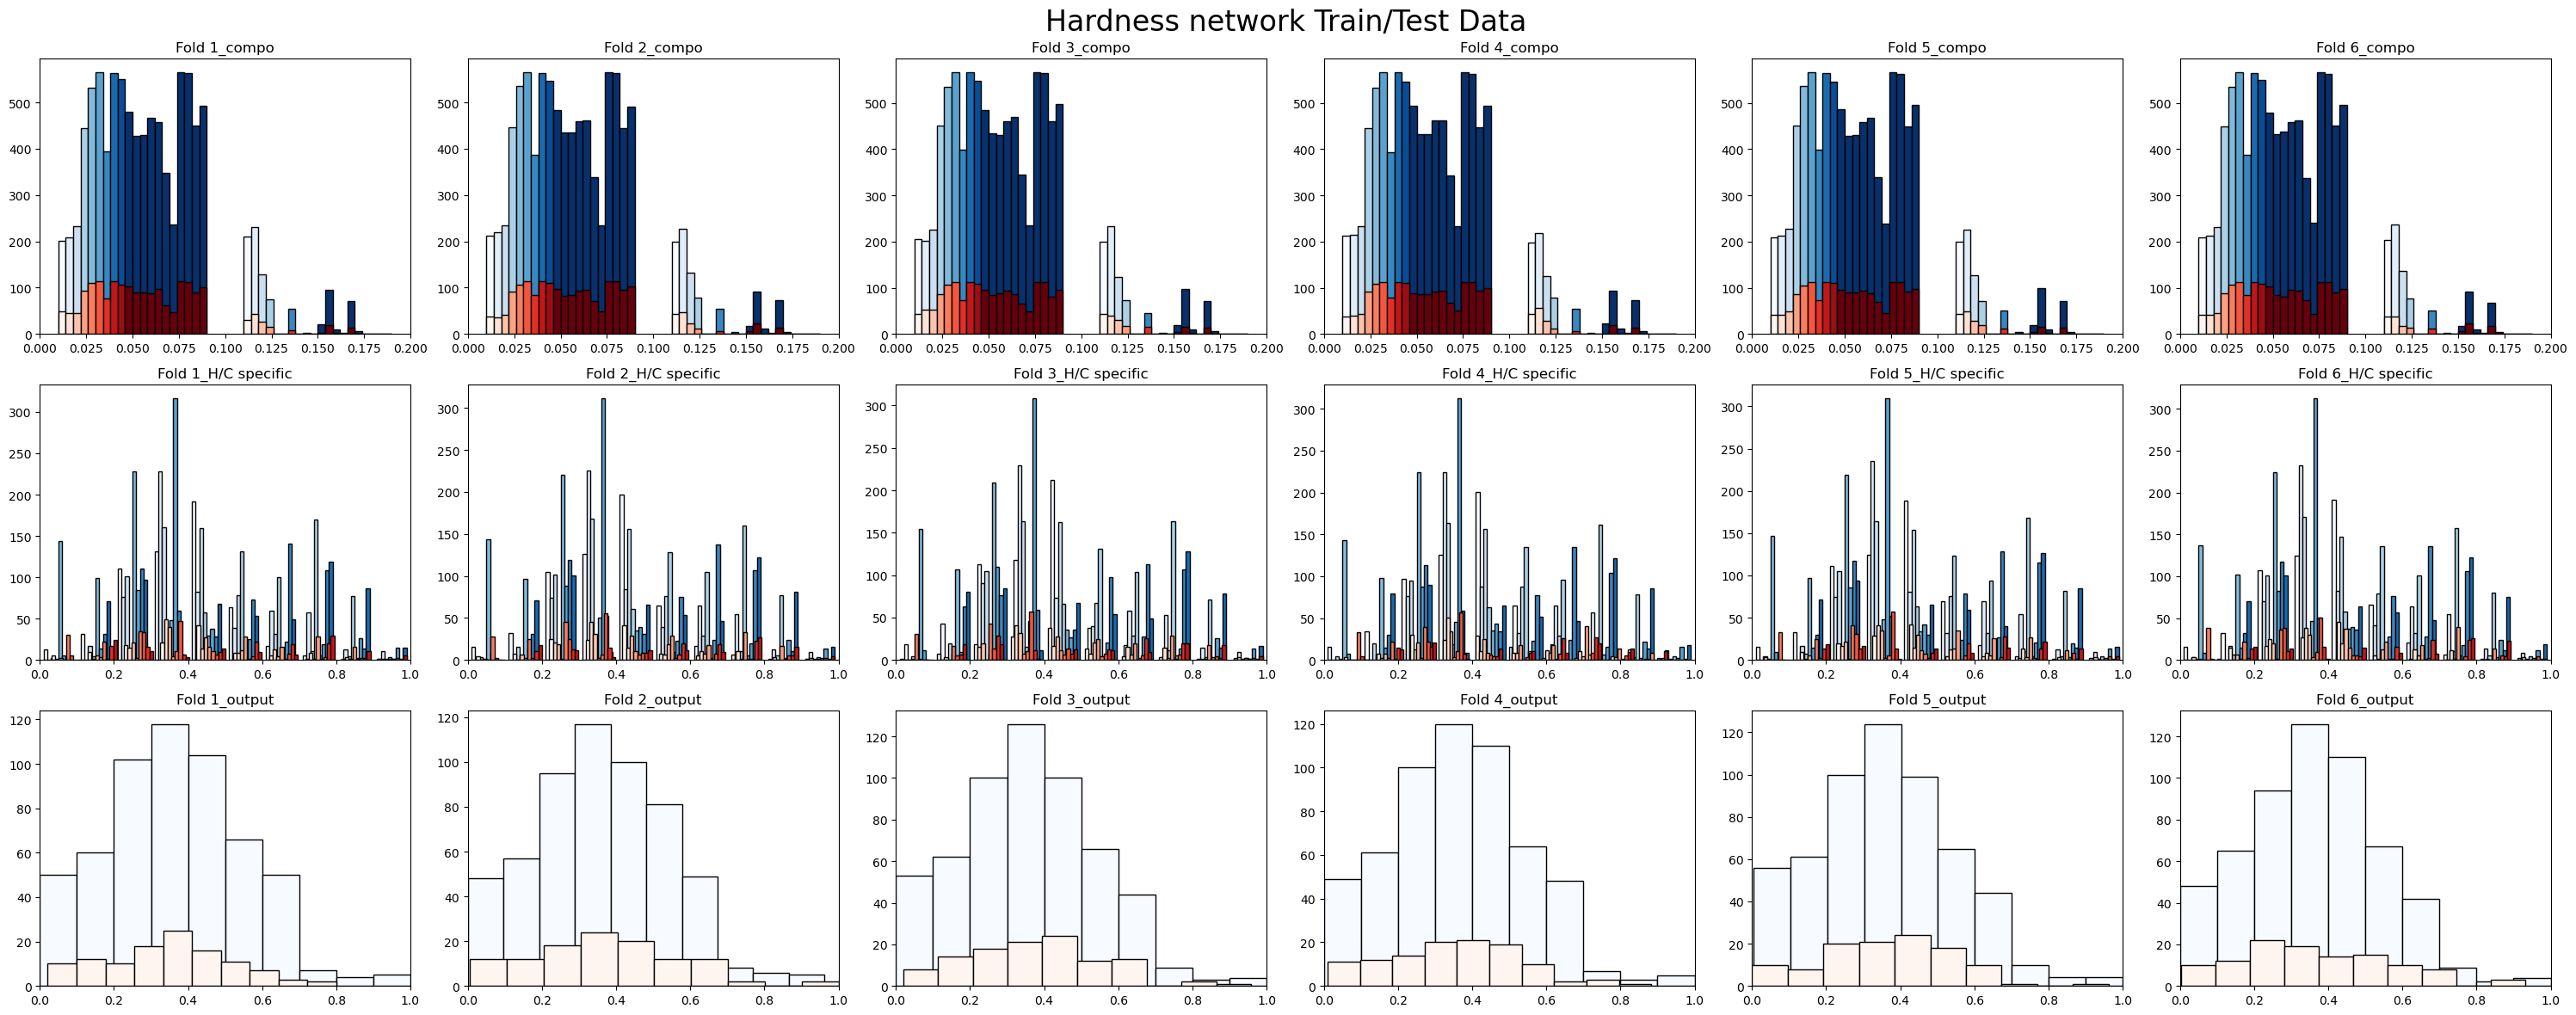

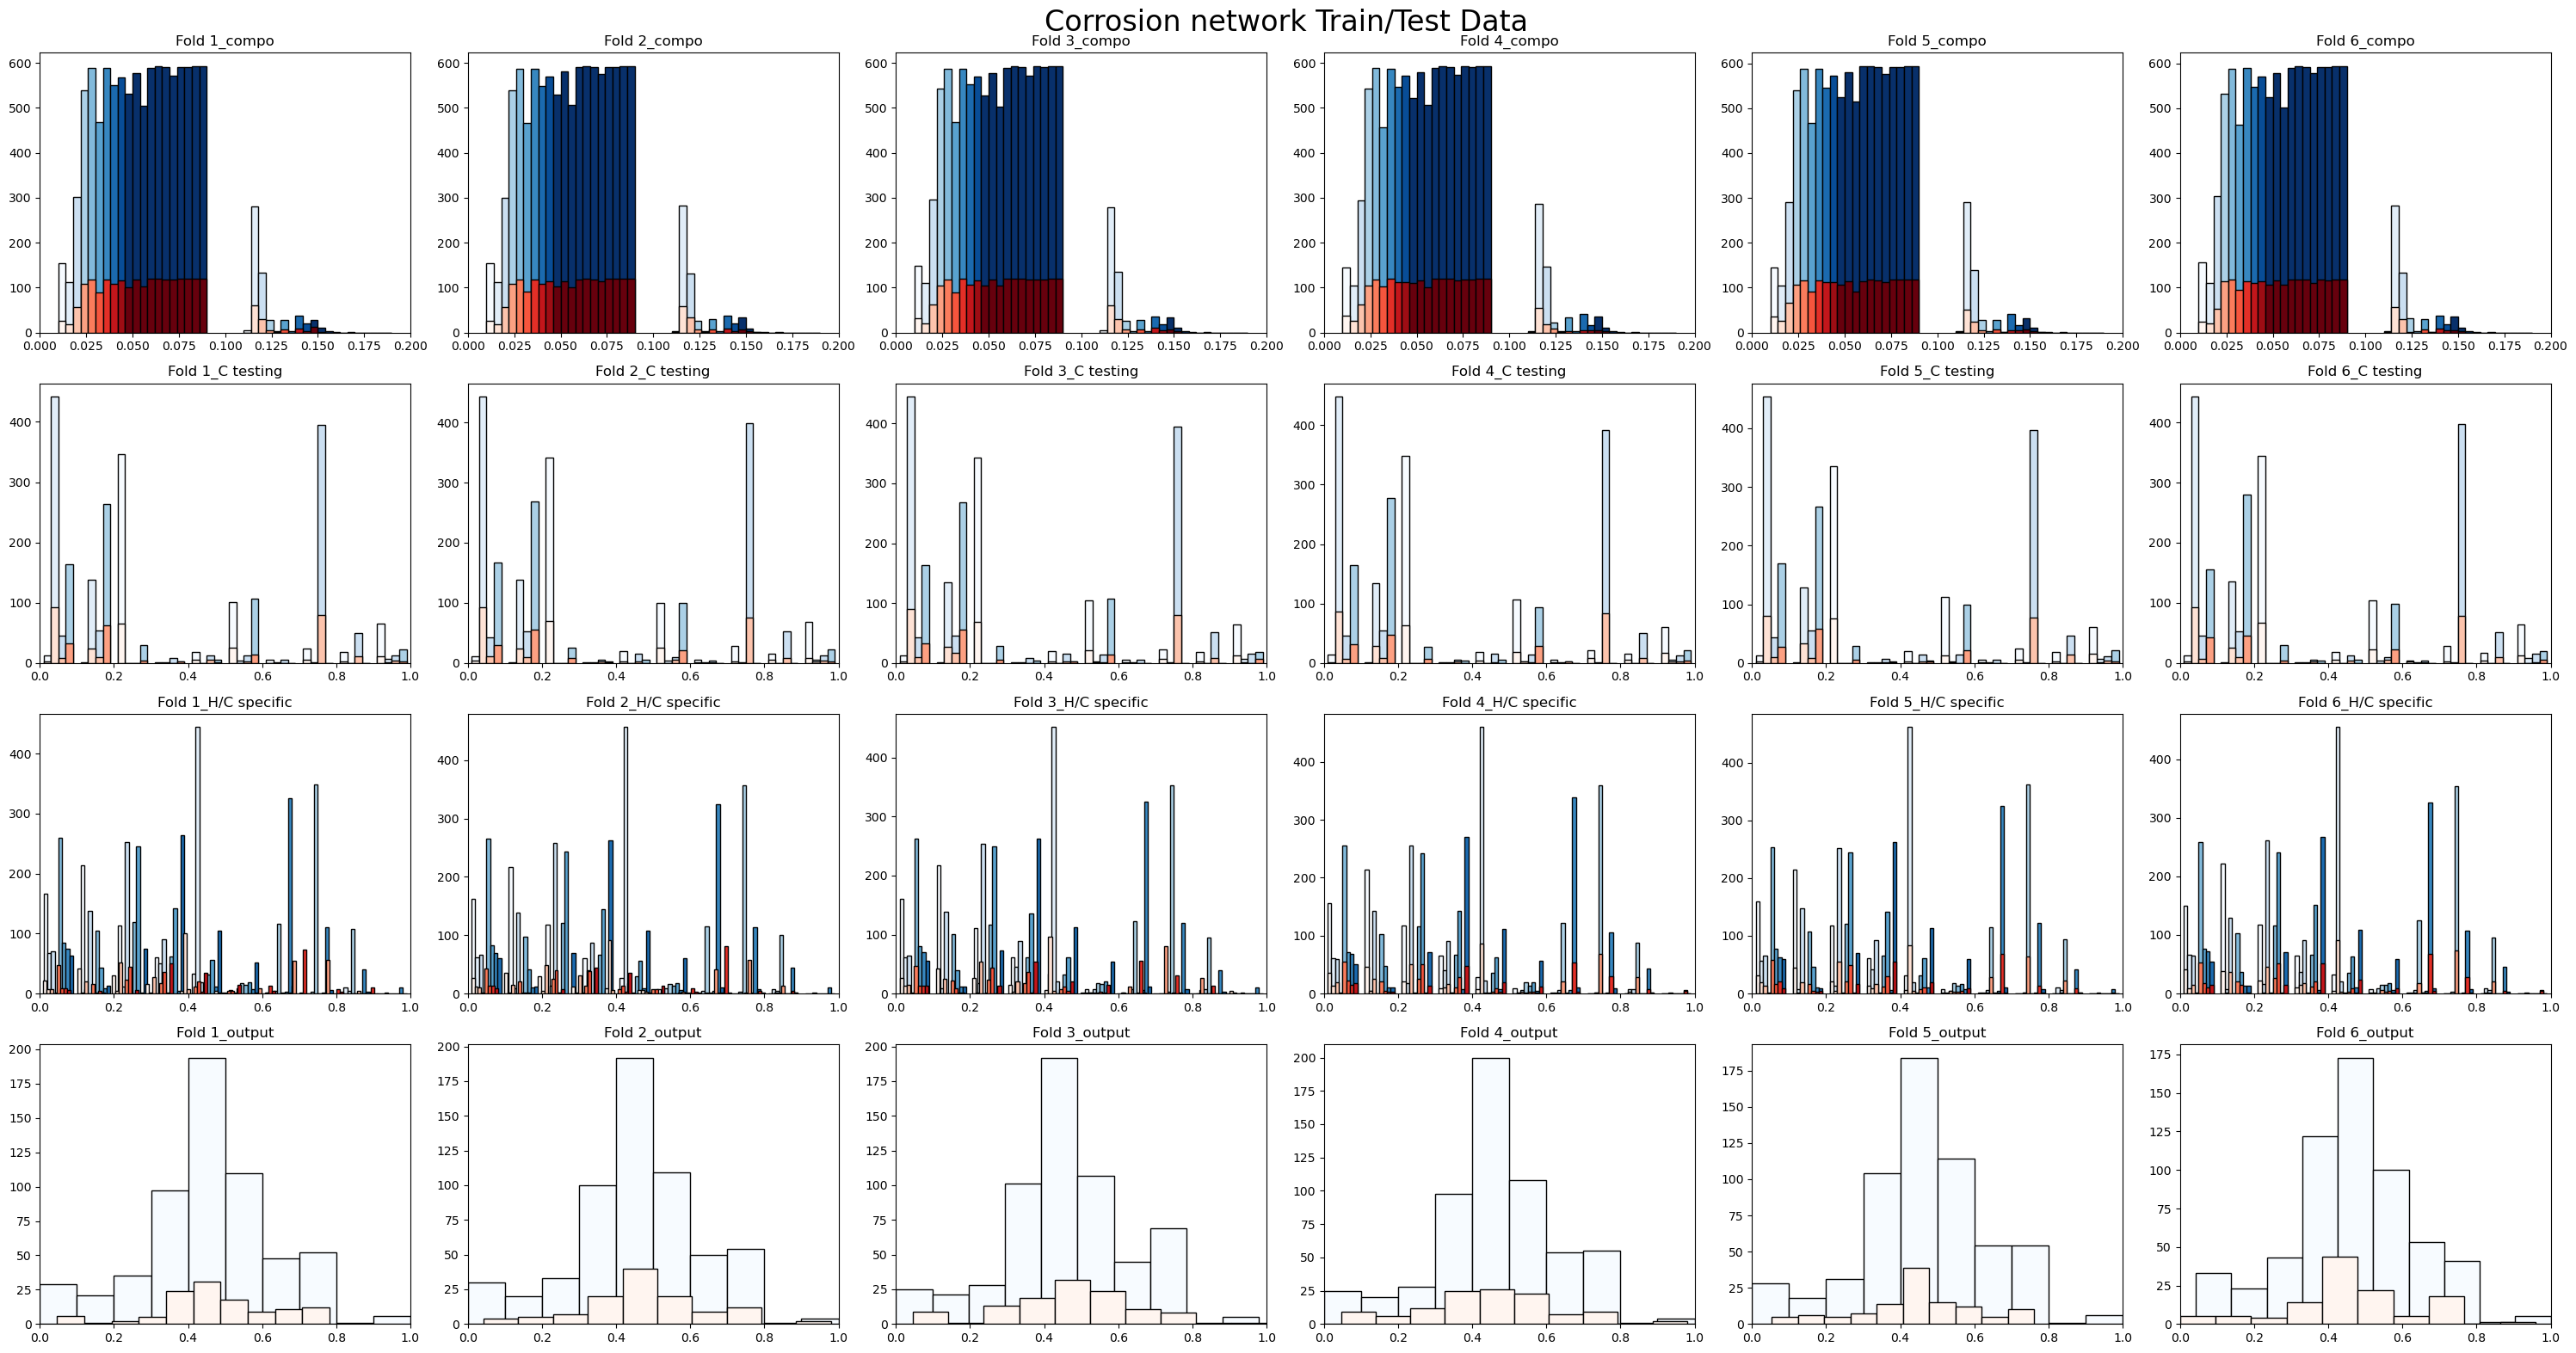

In [8]:
from utils.preprocessing_kfold_norm import plot_hist_kfold_with_norm

# call the function to plot the histograms - hardness network
plot_hist_kfold_with_norm(train_data=(X1_train_norm_KFold, V1_train_norm_KFold, H1_train_norm_KFold),
                          test_data=(X1_test_norm_KFold,
                                     V1_test_norm_KFold,  H1_test_norm_KFold),
                          x_min=(0, 0, 0),
                          x_max=(0.2, 1, 1),
                          axs_title='Hardness network Train/Test Data',
                          n_splits=6, n_repeats=1, nrows=3, dataset='H')


# call the function to plot the histograms - corrosion network
plot_hist_kfold_with_norm(train_data=(X2_train_norm_KFold, Z2_train_norm_KFold, W2_train_norm_KFold, C2_train_norm_KFold),
                          test_data=(X2_test_norm_KFold,  Z2_test_norm_KFold,
                                     W2_test_norm_KFold, C2_test_norm_KFold),
                          x_min=(0, 0, 0, 0),
                          x_max=(0.2, 1, 1, 1),
                          axs_title='Corrosion network Train/Test Data',
                          n_splits=6, n_repeats=1, nrows=4, dataset='C')

## NN architecture, creation, evaluation:

- shared feature NN: NNF
- hardness NN: NNH
- corrosion NN: NNC

class: `MultiTaskNN`


In [9]:
if Flag_Training_try:

    from utils.multitask_nn import MultiTaskNN

    start_time = time.time()
    mt_nn = MultiTaskNN(NNF_num_nodes=64, NNF_num_layers=0,
                        NNH_num_nodes=64, NNH_num_layers=4,
                        NNC_num_nodes=64, NNC_num_layers=3,
                        mc_state=True, act='relu',
                        NNF_dropout=0.25, NNH_dropout=0.25, NNC_dropout=0.25,
                        loss_func=tf.keras.metrics.mean_squared_error,
                        learning_rate_H=0.001, learning_rate_C=0.001,
                        batch_size_H=32,
                        N_epochs_local=1, total_epochs=50,
                        model_save_flag=True, model_path_bo=model_path_bo)

    # inputs for `RepeatedKFold`
    k_folds, n_CVrepeats = 6, 2

    # train_loss/val_loss: training/validation loss history
    # score_loss/score_r2: evaluated loss score/R2 score

    (train_loss_H, train_loss_C,
     val_loss_H,    val_loss_C,
     score_loss_H,  score_loss_C,
     score_r2_H,    score_r2_C) = mt_nn.evaluate_NN_full_model(X1_train_norm_KFold, X1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold,
                                                               X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold,
                                                               k_folds, n_CVrepeats)
    elapsed_time = time.time() - start_time
    print("Time taken: ", int(elapsed_time), "seconds")


Time taken:  49 seconds


training quality for NNH_model and NNC_model


In [10]:
if Flag_Training_try:
    # training results by score_loss
    # print([f'{x:.4f}' for x in score_loss_H])
    # print([f'{x:.4f}' for i in range(12) for x in val_loss_H[i][-1]])
    print(
        f"score_loss_H: {np.mean(score_loss_H):.4f} ({np.std(score_loss_H):.4f})")

    # print([f'{x:.4f}' for x in score_loss_C])
    # print([f'{x:.4f}' for i in range(12) for x in val_loss_C[i][-1]])
    print(
        f"score_loss_C: {np.mean(score_loss_C):.4f} ({np.std(score_loss_C):.4f})")

    # training results by score_r2
    # print([f'{x:.4f}' for x in score_r2_H])
    print(
        f"score_r2_H:   {np.mean(score_r2_H):.4f} ({np.std(score_r2_H):.4f})")

    # print([f'{x:.4f}' for x in score_r2_C])
    print(f"score_r2_C: {np.mean(score_r2_C):.4f} ({np.std(score_r2_C):.4f})")

    print(f"score_r2_HC: {np.mean([score_r2_H, score_r2_C]):.4f}")

score_loss_H: 0.0177 (0.0020)
score_loss_C: 0.0129 (0.0012)
score_r2_H:   0.6035 (0.0342)
score_r2_C: 0.6493 (0.0553)
score_r2_HC: 0.6264


plot the loss history


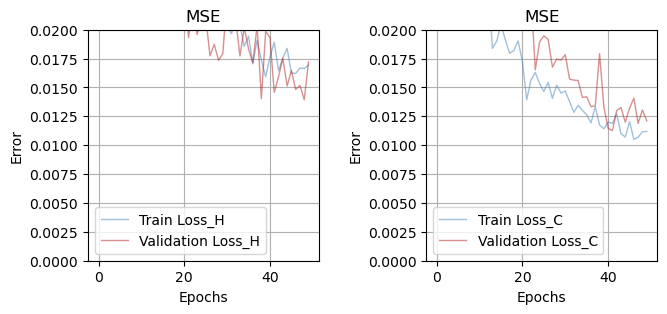

In [11]:
mt_nn.plot_losses(train_loss_H, val_loss_H, train_loss_C,
                  val_loss_C, k_folds=6, n_CVrepeats=2)


## Bayesian Hyperparameter Optimisation

class: `BO_hyper_objective`


Search domain


In [12]:
# Define the search space for hyperparameters
search_space_NNF_NNH_NNC = [{'name': 'NNF_num_nodes',   'type': 'discrete',  'domain': (32, 64, 128, 256)},  # 0: NNF_num_nodes
                            {'name': 'NNF_num_layers',  'type': 'discrete',
                                'domain': (1, 2, 3, 4, 5, 6)},  # 1: NNF_num_layers
                            {'name': 'NNH_num_nodes',   'type': 'discrete',
                                'domain': (32, 64, 128, 256)},  # 2: NNH_num_nodes
                            {'name': 'NNH_num_layers',  'type': 'discrete',
                                'domain': (1, 2, 3, 4, 5, 6)},  # 3: NNH_num_layers
                            {'name': 'NNC_num_nodes',   'type': 'discrete',
                                'domain': (32, 64, 128, 256)},  # 4: NNC_num_nodes
                            {'name': 'NNC_num_layers',  'type': 'discrete',
                                'domain': (1, 2, 3, 4, 5, 6)},  # 5: NNC_num_layers
                            {'name': 'NNF_dropout',     'type': 'continuous',
                                'domain': (0.1, 0.5)},         # 6: NNF_dropout
                            {'name': 'NNH_NNC_dropout', 'type': 'continuous',
                                'domain': (0.1, 0.5)},         # 7: NNH_NNC_dropout
                            {'name': 'loss_class',      'type': 'discrete',
                                'domain': (0, 1)},             # 8: loss_class
                            {'name': 'learning_rate_H', 'type': 'continuous',
                                'domain': (0.0001, 0.01)},     # 9: learning_rate_H
                            {'name': 'learning_rate_C', 'type': 'continuous',
                                'domain': (0.0001, 0.01)},     # 10: learning_rate_C
                            {'name': 'batch_size_H',    'type': 'discrete',
                                'domain': (16, 32, 64, 128)},  # 11: batch_size_H
                            {'name': 'N_epochs_local',  'type': 'discrete',  'domain': (1, 2, 3, 4)}]       # 12: N_epochs_global


BO hyperparameter optimisation


In [13]:
# if Flag_BO_search:
from utils.BO_hyper_objective import BayesianOptimizationObjective

start_time = time.time()

# Set up the optimizer
bo = None
bo_iteration = 0

score_r2_HC_list, score_loss_HC_list, score_r2_H_list, score_r2_C_list, score_loss_H_list, score_loss_C_list = [], [], [], [], [], []
n_initial_points, n_iterations = 1, 1
mc_state, act = True, 'relu'
total_epochs = 50
model_save_flag = False
k_folds, n_CVrepeats = 6, 2
np.random.seed(bo_ens_num)

bo_obj = BayesianOptimizationObjective(bo_ens_num, model_path_bo)

bo = GPyOpt.methods.BayesianOptimization(f=lambda x: bo_obj.BO_NNF_NNH_NNC_objective(x, n_initial_points, n_iterations,
                                                                                     mc_state, act,
                                                                                     total_epochs,
                                                                                     model_save_flag, model_path_bo,
                                                                                     X1_train_norm_KFold, X1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold,
                                                                                     X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold,
                                                                                     k_folds, n_CVrepeats,
                                                                                     score_r2_HC_list, score_loss_HC_list,
                                                                                     score_r2_H_list, score_r2_C_list,
                                                                                     score_loss_H_list, score_loss_C_list)[0],  # Use only score_r2 as objective function
                                         domain=search_space_NNF_NNH_NNC,
                                         model_type='GP',
                                         initial_design_numdata=n_initial_points,
                                         init_design_type='random',
                                         acquisition_type='EI',
                                         acquisition_optimizer_type='lbfgs',
                                         acquisition_jitter=0,
                                         maximize=True)

bo.run_optimization(max_iter=n_iterations)
# Print the best hyperparameters and objective value found
best_hyperparameters = ", ".join("{:.4f}".format(h) for h in bo.x_opt)
print("Best hyperparameters: {}".format(best_hyperparameters))
print("Best objective value:", -bo.fx_opt)
elapsed_time = time.time() - start_time
print("Time taken: ", int(elapsed_time), "seconds")


Iteration: 1/2
Iteration: 2/2
Best hyperparameters: 128.0000, 6.0000, 128.0000, 3.0000, 32.0000, 3.0000, 0.2964, 0.4120, 0.0000, 0.0042, 0.0058, 32.0000, 4.0000
Best objective value: 0.27781570458838406
Time taken:  114 seconds


### Save the BO hypertable


In [14]:
# if Flag_BO_search:

# update the hypertable
bo_obj.update_hypertable(bo, score_r2_HC_list, score_loss_HC_list,
                         score_r2_H_list, score_r2_C_list, score_loss_H_list, score_loss_C_list)

# Save the sorted data to an Excel file
bo_obj.hypertable.to_excel(model_path_bo +
                           f"hypertable_NN_full_RepeatedKFold_v3_bo_ens_{bo_ens_num}.xlsx", index=False)

# sort the list start from the best results
hypertable_sort = bo_obj.hypertable.sort_values(
    by=['score_r2_HC'], ascending=False, ignore_index=True)

display(hypertable_sort.head())

# Save the sorted data to an Excel file
hypertable_sort.to_excel(model_path_bo +
                         f"hypertable_sort_NN_full_RepeatedKFold_v3_bo_ens_{bo_ens_num}.xlsx", index=False)

score_r2_HC  score_r2_HC_best  score_loss_HC  score_r2_H  score_r2_C  \
0     0.277816          0.277816       0.027392    0.074219    0.481413   
1     0.275903          0.277816       0.127655    0.258572    0.293235   

   score_loss_H  score_loss_C  NNF_num_nodes  NNF_num_layers  NNH_num_nodes  \
0      0.037315      0.017468          128.0             6.0          128.0   
1      0.137550      0.117761           64.0             6.0           64.0   

   NNH_num_layers  NNC_num_nodes  NNC_num_layers  NNF_dropout  \
0             3.0           32.0             3.0     0.296448   
1             1.0           64.0             5.0     0.336399   

   NNH_NNC_dropout  loss_encoder  learning_rate_H  learning_rate_C  \
0         0.412011           0.0         0.004168         0.005839   
1         0.204905           1.0         0.005600         0.002254   

   batch_size_H  N_epochs_local  
0          32.0             4.0  
1          64.0             1.0

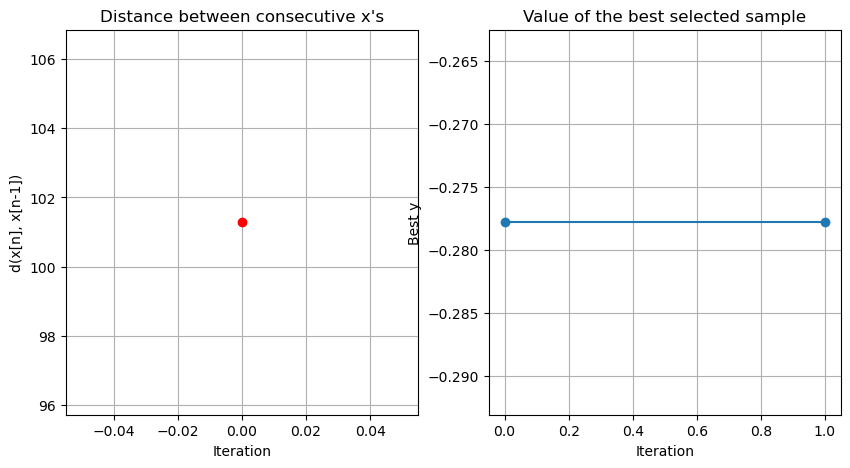

In [15]:
# if Flag_BO_search:
# plot the convergence
bo.plot_convergence()

### plotting the BO process


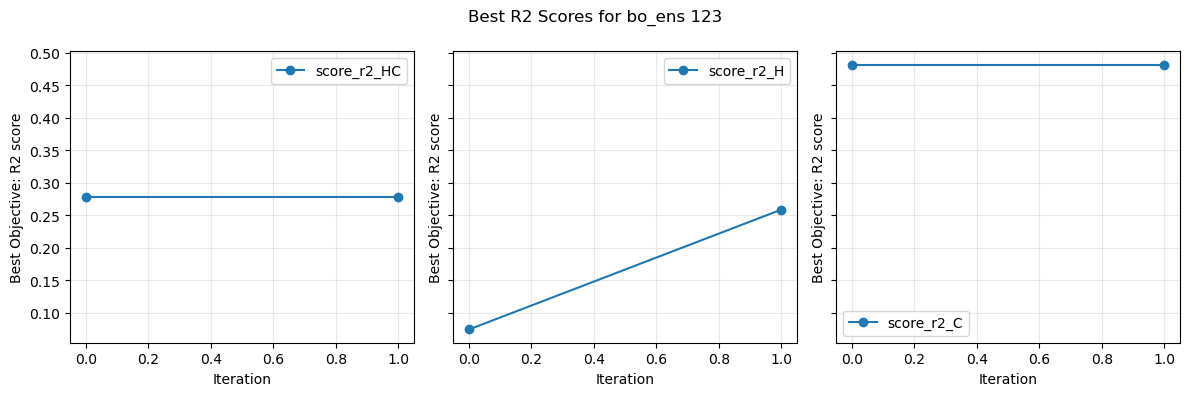

In [16]:
# if Flag_BO_search:
bo_obj.plot_best_r2_score()

## Model training: using best BO hyperparameters


In [17]:
# if Flag_Training_BO_best:
start_time = time.time()

# loading the best BO hyperparameters
hypertable_sort = pd.read_excel(
    model_path_bo + f"hypertable_sort_NN_full_RepeatedKFold_v3_bo_ens_{bo_ens_num}.xlsx")
display(hypertable_sort.head(1))
#
# inputs for `RepeatedKFold`
k_folds, n_CVrepeats = 6, 2

loss_encoder = int(hypertable_sort.loc[0, 'loss_encoder'])
if loss_encoder == 0:
    loss_func = tf.keras.metrics.mean_squared_error
elif loss_encoder == 1:
    loss_func = tf.keras.metrics.mean_absolute_error
else:
    raise ValueError(f"Invalid loss function '{loss_encoder}' ")


mt_nn_BObest = MultiTaskNN(NNF_num_nodes=int(hypertable_sort.loc[0, 'NNF_num_nodes']), NNF_num_layers=int(hypertable_sort.loc[0, 'NNF_num_layers']),
                           NNH_num_nodes=int(hypertable_sort.loc[0, 'NNH_num_nodes']), NNH_num_layers=int(hypertable_sort.loc[0, 'NNH_num_layers']),
                           NNC_num_nodes=int(hypertable_sort.loc[0, 'NNC_num_nodes']), NNC_num_layers=int(hypertable_sort.loc[0, 'NNC_num_layers']),
                           mc_state=True, act='relu',
                           NNF_dropout=hypertable_sort.loc[0, 'NNF_dropout'],
                           NNH_dropout=hypertable_sort.loc[0,
                                                           'NNH_NNC_dropout'],
                           NNC_dropout=hypertable_sort.loc[0,
                                                           'NNH_NNC_dropout'],
                           loss_func=tf.keras.metrics.mean_squared_error,
                           learning_rate_H=hypertable_sort.loc[0,
                                                               'learning_rate_H'],
                           learning_rate_C=hypertable_sort.loc[0,
                                                               'learning_rate_C'],
                           batch_size_H=int(
                               hypertable_sort.loc[0, 'batch_size_H']),
                           N_epochs_local=int(hypertable_sort.loc[0, 'N_epochs_local']), total_epochs=50,
                           model_save_flag=True, model_path_bo=model_path_bo)

# evaluate model
(train_loss_H, train_loss_C,
 val_loss_H,    val_loss_C,
 score_loss_H,  score_loss_C,
 score_r2_H,    score_r2_C) = mt_nn_BObest.evaluate_NN_full_model(X1_train_norm_KFold, X1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold,
                                                                  X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold,
                                                                  k_folds, n_CVrepeats)

elapsed_time = time.time() - start_time
print("Time taken: ", int(elapsed_time), "seconds")


score_r2_HC  score_r2_HC_best  score_loss_HC  score_r2_H  score_r2_C  \
0     0.277816          0.277816       0.027392    0.074219    0.481413   

   score_loss_H  score_loss_C  NNF_num_nodes  NNF_num_layers  NNH_num_nodes  \
0      0.037315      0.017468            128               6            128   

   NNH_num_layers  NNC_num_nodes  NNC_num_layers  NNF_dropout  \
0               3             32               3     0.296448   

   NNH_NNC_dropout  loss_encoder  learning_rate_H  learning_rate_C  \
0         0.412011             0         0.004168         0.005839   

   batch_size_H  N_epochs_local  
0            32               4

Time taken:  52 seconds


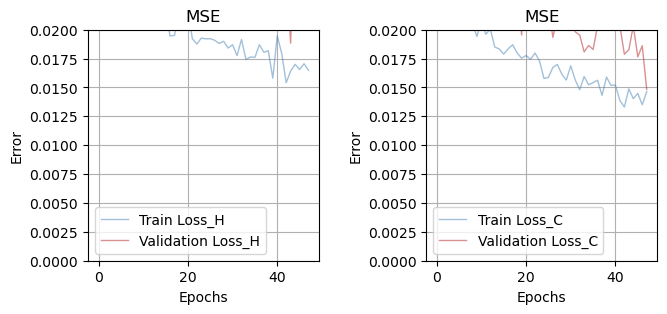

In [18]:
mt_nn_BObest.plot_losses(train_loss_H, val_loss_H, train_loss_C,
                         val_loss_C, k_folds=6, n_CVrepeats=2)

## Evaluate the training results

#### Show the model.h5 files in this directory


In [19]:
# # if Flag_Training_BO_best:


# # list all files in the directory
# files = sorted([f for f in os.listdir(model_path_bo) if f.endswith('.h5')])
# # create a table with the headers "NNH_model" and "NNC_model"
# table = [["NNH_model", "NNC_model"]]
# # loop through all files and add the filenames to the appropriate list
# nnh_files = [f for f in files if f.startswith('NNH_model_RepeatedKFold')]
# nnc_files = [f for f in files if f.startswith('NNC_model_RepeatedKFold')]
# # sort NNH_model files and NNC_model files by their integer suffix
# nnh_files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
# nnc_files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
# # add the filenames to the table
# for i in range(12):
#     nnh_file = nnh_files[i] if i < len(nnh_files) else ""
#     nnc_file = nnc_files[i] if i < len(nnc_files) else ""
#     table.append([nnh_file, nnc_file])
# # display the table
# print(tabulate(table, headers="firstrow"))


In [1]:
# def display_saved_models(model_path_bo):
#     # list all files in the directory
#     files = sorted([f for f in os.listdir(model_path_bo) if f.endswith('.h5')])

#     # create a table with the headers "NNH_model" and "NNC_model"
#     table = [["NNH_model", "NNC_model"]]

#     # loop through all files and add the filenames to the appropriate list
#     nnh_files = [f for f in files if f.startswith('NNH_model_RepeatedKFold')]
#     nnc_files = [f for f in files if f.startswith('NNC_model_RepeatedKFold')]

#     # sort NNH_model files and NNC_model files by their integer suffix
#     nnh_files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
#     nnc_files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))

#     # add the filenames to the table
#     for i in range(12):
#         nnh_file = nnh_files[i] if i < len(nnh_files) else ""
#         nnc_file = nnc_files[i] if i < len(nnc_files) else ""
#         table.append([nnh_file, nnc_file])

#     # display the table
#     print(tabulate(table, headers="firstrow"))
from utils.postprocessing_evalutation import display_saved_models

display_saved_models(model_path_bo)


ModuleNotFoundError: No module named 'utils'

In [25]:
import pickle

# Save the scalers dictionary to a file using pickle
with open(data_path + 'scalers.pkl', 'wb') as f:
    pickle.dump(scalers, f)

scalers


{'compo': MinMaxScaler(),
 'H_specific_testing': MinMaxScaler(),
 'C_specific_testing': MinMaxScaler(),
 'specific_features': MinMaxScaler(),
 'H_output': MinMaxScaler(),
 'C_output': MinMaxScaler()}

### Check the training quality


#### define `predict_bootstrap` for prediction


In [36]:
# def predict_bootstrap(model_path, model_name,
#                       X1_list, Y1_list, V1_list,
#                       k_folds, n_CVrepeats, mc_repeat,
#                       scaler_compo, scaler_testing, scaler_specific, scaler_output):

#     H1_pred_X1_list = []
#     H1_pred_X1_mc_mean = []
#     H1_pred_X1_mc_std = []

#     def predict_one_model(i):

#         # loading saved models
#         NNH_model_loaded_temp = keras.models.load_model(
#             os.path.join(model_path, model_name.format(i+1)))

#         # concatenating the X1_list and V1_list and normalisation
#         X1_temp_norm = scaler_compo.transform(X1_list[i])
#         if len(Y1_list) != 0:  # if testing condition for C is defined
#             Y1_temp_norm = scaler_testing.transform(Y1_list[i])
#         V1_temp_norm = scaler_specific.transform(V1_list[i])

#         X1_V1_temp_norm = np.concatenate([X1_temp_norm, V1_temp_norm], axis=1)

#         # make predictions

#         if len(Y1_list) != 0:  # if testing condition for C is defined

#             def predict_one_sample():
#                 return scaler_output.inverse_transform(
#                     NNH_model_loaded_temp.predict(
#                         [X1_V1_temp_norm, Y1_temp_norm], verbose=0)
#                 )
#         elif len(Y1_list) == 0:  # if testing condition for H is NOT defined
#             def predict_one_sample():
#                 return scaler_output.inverse_transform(
#                     NNH_model_loaded_temp.predict(X1_V1_temp_norm, verbose=0)
#                 )

#         H1_pred_X1_mc_stack_temp = tf.map_fn(lambda _: predict_one_sample(),
#                                              tf.range(mc_repeat),
#                                              dtype=tf.float32,
#                                              parallel_iterations=mc_repeat)

#         H1_pred_X1_mc_mean_temp = np.mean(
#             H1_pred_X1_mc_stack_temp, axis=0).reshape((-1,))

#         H1_pred_X1_mc_std_temp = np.std(
#             H1_pred_X1_mc_stack_temp,  axis=0).reshape((-1,))

#         return H1_pred_X1_mc_stack_temp, H1_pred_X1_mc_mean_temp, H1_pred_X1_mc_std_temp

#     results = Parallel(n_jobs=-1)(delayed(predict_one_model)(i)
#                                   for i in range(k_folds * n_CVrepeats))

#     # clear TensorFlow session
#     tf.keras.backend.clear_session()

#     for mc_stack, mean, std in results:
#         H1_pred_X1_list.append(mc_stack)
#         H1_pred_X1_mc_mean.append(mean)
#         H1_pred_X1_mc_std.append(std)

#     return H1_pred_X1_list, H1_pred_X1_mc_mean, H1_pred_X1_mc_std

#### compute true vs predictions (test data) for each RepeatedKFold


In [37]:
a = []
len(a)


0

In [38]:
# # if Flag_Training_BO_best:
# #     mc_repeat = 50

#     NNH_model_name = 'NNH_model_RepeatedKFold_{}.h5'
#     NNC_model_name = 'NNC_model_RepeatedKFold_{}.h5'

with concurrent.futures.ThreadPoolExecutor() as executor:
    future1 = executor.submit(predict_bootstrap, model_path_bo, NNH_model_name='NNH_model_RepeatedKFold_{}.h5',
                              X1_test_KFold, [], V1_test_KFold,
                              k_folds=6, n_CVrepeats=2, mc_repeat=50,
                              scalers["compo"], [], scalers["specific_features"], scalers["H_output"])

    future2 = executor.submit(predict_bootstrap, model_path_bo, NNC_model_name='NNC_model_RepeatedKFold_{}.h5',
                              X2_test_KFold, Z2_test_KFold, W2_test_KFold,
                              k_folds=6, n_CVrepeats=2, mc_repeat=50,
                              scalers["compo"], scalers["C_specific_testing"], scalers["specific_features"], scalers["C_output"])

H1_test_pred_X1_stack, H1_test_pred_X1_mean, H1_test_pred_X1_std = future1.result()
C2_test_pred_X2_stack, C2_test_pred_X2_mean, C2_test_pred_X2_std = future2.result()


Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7f23534ded30>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7ffad7d5adc0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7f94c60d4d30>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7f9f59f01d30>: no matching AST found among candidates:

To silence thi

#### define `plot_test_true_vs_pred` for true vs predictions (test data)


In [39]:
# def plot_test_true_vs_pred(k_folds, n_CVrepeats, test_KFold, test_pred_mean, test_pred_std, lims, label, color, model_path):

#     fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(18, 7))

#     for i in range(k_folds * n_CVrepeats):
#         # ----- plot true vs prediction -----
#         row_idx = i // 6
#         col_idx = i % 6
#         ax[row_idx, col_idx].set_xlim(lims)
#         ax[row_idx, col_idx].set_ylim(lims)
#         ax[row_idx, col_idx].plot(lims, lims, color='grey')
#         ax[row_idx, col_idx].scatter(
#             test_KFold[i], test_pred_mean[i], label=label, color=color, alpha=0.5)
#         ax[row_idx, col_idx].errorbar(x=test_KFold[i], y=test_pred_mean[i], yerr=test_pred_std[i], fmt='none',
#                                       ecolor=color, capsize=3, alpha=0.5)
#         r = r2_score(test_KFold[i], test_pred_mean[i])
#         ax[row_idx, col_idx].text(.05, .7, 'r2={:.2f}'.format(
#             r), transform=ax[row_idx, col_idx].transAxes, color=color)
#         ax[row_idx, col_idx].set_xlabel('True values in training dataset')
#         ax[row_idx, col_idx].set_ylabel('Predictions')
#         ax[row_idx, col_idx].set_aspect('equal', 'box')
#         ax[row_idx, col_idx].legend(loc=4, prop={'size': 8})
#         ax[row_idx, col_idx].grid()

#     # adjust spacing and show plot
#     fig.tight_layout()
#     axs_title = label + '_RepeatedKFold_True_Prediction_testdata'
#     fig.suptitle(axs_title, fontsize=18)
#     plt.savefig(model_path + axs_title + '.png', bbox_inches='tight')
#     plt.show()

#### plot true vs predictions (test data) for each RepeatedKFold


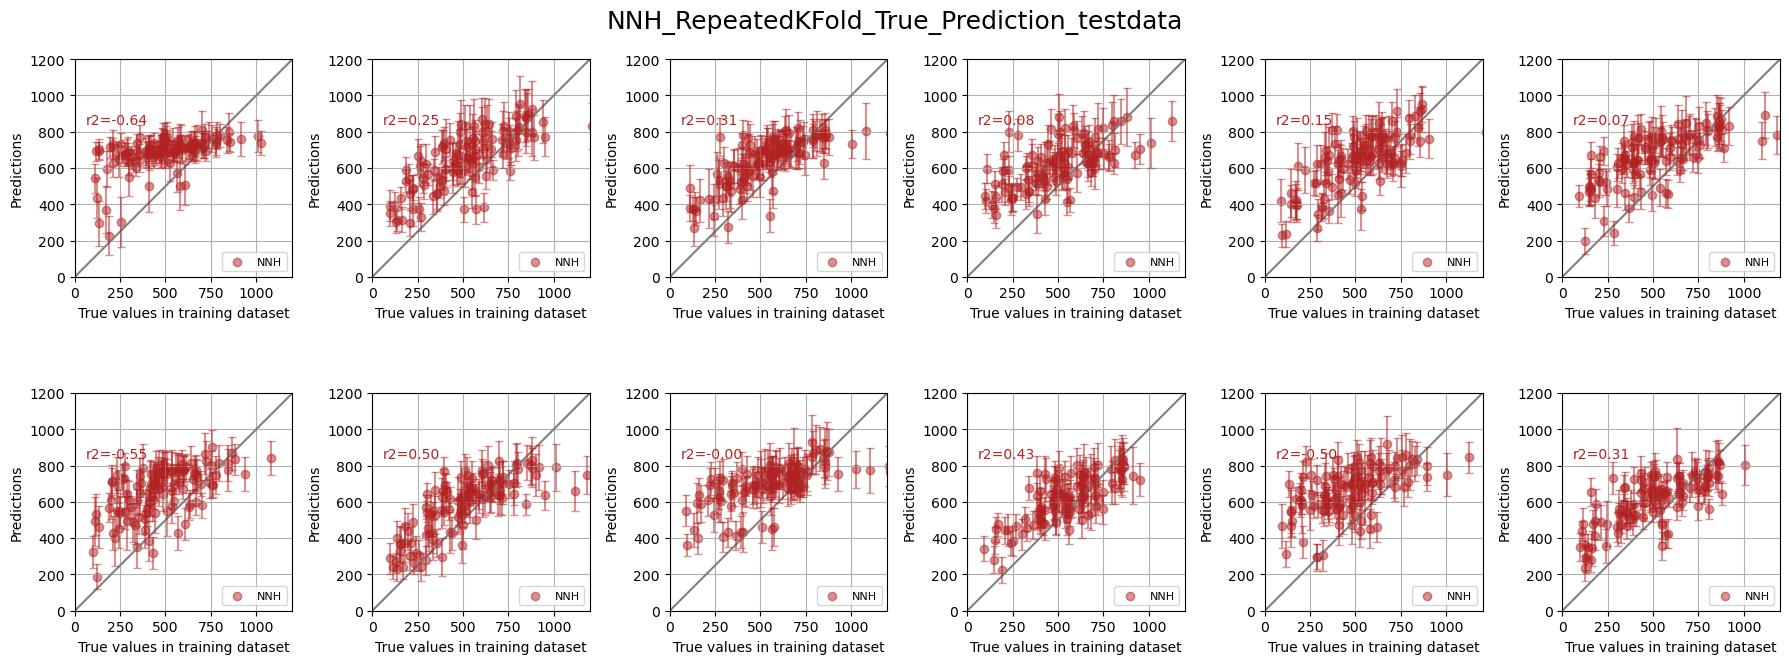

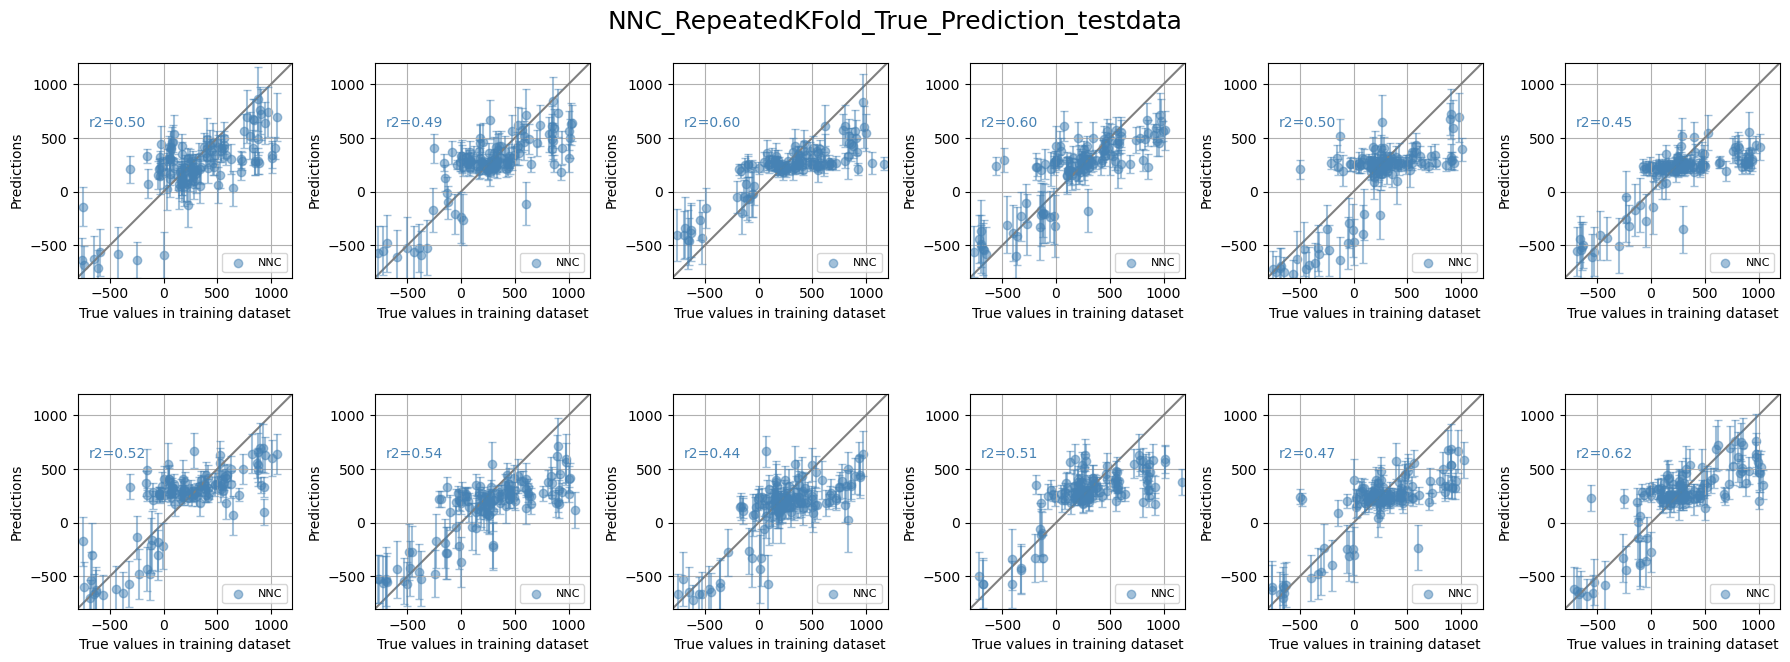

In [40]:
if Flag_Training_BO_best:
    plot_test_true_vs_pred(k_folds, n_CVrepeats, H1_test_KFold, H1_test_pred_X1_mean, H1_test_pred_X1_std,
                           [0, 1200], 'NNH', 'firebrick', model_path_bo)

    plot_test_true_vs_pred(k_folds, n_CVrepeats, C2_test_KFold, C2_test_pred_X2_mean, C2_test_pred_X2_std,
                           [-800, 1200], 'NNC', 'steelblue', model_path_bo)

### make true vs predictions (based on the full dataset)


In [41]:
X1_list, Y1_list, V1_list = [X1]*k_folds * \
    n_CVrepeats, [], [V1]*k_folds*n_CVrepeats
X2_list, Z2_list, W2_list = [
    X2]*k_folds*n_CVrepeats, [Z2]*k_folds*n_CVrepeats, [W2]*k_folds*n_CVrepeats

with concurrent.futures.ThreadPoolExecutor() as executor:
    future1 = executor.submit(predict_bootstrap, model_path_bo, NNH_model_name,
                              X1_list, Y1_list, V1_list,
                              k_folds=6, n_CVrepeats=2, mc_repeat=50,
                              scalers["compo"], [], scalers["specific_features"], scalers["H_output"])

    future2 = executor.submit(predict_bootstrap, model_path_bo, NNC_model_name,
                              X2_list, Z2_list, W2_list,
                              k_folds=6, n_CVrepeats=2, mc_repeat=50,
                              scalers["compo"], scalers["C_specific_testing"], scalers["specific_features"], scalers["C_output"])

H1_pred_X1_stack, H1_pred_X1_mean, H1_pred_X1_std = future1.result()
C2_pred_X2_stack, C2_pred_X2_mean, C2_pred_X2_std = future2.result()


Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7f58d05e3d30>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7f6560027dc0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7f3899552d30>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7fea171a1dc0>: no matching AST found among candidates:

To silence thi

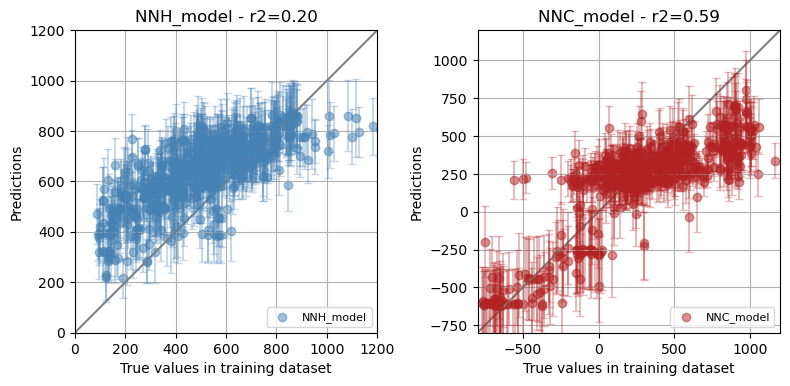

In [48]:
# if Flag_Training_BO_best:
# def plot_full_true_vs_pred(HC_list, HC_pred_stack_list, model_path_bo, lims):

#     # concatenate along the first axis
#     H1_pred_X1_conc = np.concatenate(HC_pred_stack_list[0], axis=0)
#     H1_pred_X1_KFold_mean = np.mean(H1_pred_X1_conc, axis=0).reshape(-1)
#     H1_pred_X1_KFold_std = np.std(H1_pred_X1_conc, axis=0).reshape(-1)

#     # concatenate along the first axis
#     C2_pred_X2_conc = np.concatenate(HC_pred_stack_list[1], axis=0)
#     C2_pred_X2_KFold_mean = np.mean(C2_pred_X2_conc, axis=0).reshape(-1)
#     C2_pred_X2_KFold_std = np.std(C2_pred_X2_conc, axis=0).reshape(-1)

#     fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

#     for i, (data, label, color) in enumerate(zip([(HC_list[0], H1_pred_X1_KFold_mean, H1_pred_X1_KFold_std),
#                                                   (HC_list[1], C2_pred_X2_KFold_mean, C2_pred_X2_KFold_std)],
#                                                  ['NNH_model', 'NNC_model'],
#                                                  ['steelblue', 'firebrick'])):
#         ax[i].set(xlim=lims[i], ylim=lims[i], aspect='equal', box_aspect=1, xlabel='True values in training dataset',
#                   ylabel='Predictions', title=f'{label} - r2={r2_score(data[0], data[1]):.2f}')
#         ax[i].plot(lims[i], lims[i], color='grey')
#         ax[i].scatter(*data[:2], label=label, color=color, alpha=0.5)
#         ax[i].errorbar(x=data[0], y=data[1], yerr=data[2],
#                        fmt='none', ecolor=color, capsize=3, alpha=0.3)
#         ax[i].legend(loc=4, prop={'size': 8})
#         ax[i].grid()

#     fig.tight_layout()
#     plt.savefig(model_path_bo + 'NN_full_RepeatedKFold_True_Prediction_fulldata.png', bbox_inches='tight')
#     plt.show()


plot_full_true_vs_pred([H1, C2], [H1_pred_X1_stack, C2_pred_X2_stack],
                       model_path_bo, lims=[[0, 1200], [-800, 1200]])


# Make predictions


In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# from keras.models import Sequential
# from keras import layers
# from keras.layers import Dense, Concatenate, Dropout, BatchNormalization
# from keras.utils.vis_utils import plot_model


# from sklearn.metrics import r2_score
# from sklearn.preprocessing import MinMaxScaler
# import scipy as sp
# import seaborn as sns

# import numpy as np

# import pandas as pd
# import matplotlib.cm as cm
# import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker
# from tabulate import tabulate

# import time

# from multiprocessing import Pool
# from joblib import Parallel, delayed
# import concurrent.futures

# import pickle
# import os

# data_path  = './Dataset_Cleaned/'
# model_path = './Model_Saved/'


# # ----- BO-related -----
# notebook_fname = "NN_full_RepeatedKFold_v3_BO_1"
# num_str        = notebook_fname.split("_")[-1]

# try:
#     bo_ens_num = int(num_str)
#     print(f"bo_ens_num: {bo_ens_num}")
# except ValueError:
#     # if the string can't be converted to an integer, keep it as a string
#     bo_ens_num = int(123)
#     print(f"book master - bo_ens_num: {bo_ens_num}")


# model_path_bo = f'./{model_path}/{notebook_fname}/'

# if not os.path.exists(model_path_bo):
#     os.makedirs(model_path_bo)
#     print(f"Folder '{model_path_bo}' created.")
# else:
#     print(f"Folder '{model_path_bo}' already exists.")
# # ----- BO-related -----

# tf.keras.backend.clear_session()

#### load scalers


In [ ]:
# # Load the scalers from the file
# with open(data_path + 'scalers.pkl', 'rb') as f:
#     (scaler_compo,
#      scaler_H_specific,
#      scaler_C_specific,
#      scaler_H_output,
#      scaler_C_output) = pickle.load(f)

# Load the scalers dictionary from a file using pickle
with open(data_path + 'scalers.pkl', 'rb') as f:
    loaded_scalers = pickle.load(f)

print(loaded_scalers)

{'compo': MinMaxScaler(), 'specific_features': MinMaxScaler(), 'H_output': MinMaxScaler(), 'C_specific_testing': MinMaxScaler(), 'C_output': MinMaxScaler()}


#### coordinates for PVD alloy representation


In [ ]:
# load the wafer-coordinates
df_PVD_x_y = pd.read_excel(data_path + 'PVD_x_y.xlsx')
coord_x = df_PVD_x_y["x"].to_numpy(dtype=float)
coord_y = df_PVD_x_y["y"].to_numpy(dtype=float)
index_PVD_x_y = df_PVD_x_y.index.values+1

#### define `read_new_data` to load the inputs for making predictions


In [ ]:
def read_new_data(data_path, KW_name, vars_ele):
    # ----- import the new dataset -----
    df_new_at = pd.read_excel(
        data_path + 'MultiTaskModel_' + KW_name + '_at_pct.xlsx')
    df_new_wt = pd.read_excel(
        data_path + 'MultiTaskModel_' + KW_name + '_wt_pct.xlsx')
    vars_ele = vars_ele
    KW_name = KW_name

    # ----- get the `df_compo_new` ------
    df_compo = pd.DataFrame(columns=['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn',
                                     'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf'])

    df_compo_new = pd.concat(
        [df_compo, df_new_wt[vars_ele]], axis=0, ignore_index=True)
    df_compo_new = df_compo_new.fillna(0)  # fill in the nan by zero

    compo_new = np.asarray(df_compo_new.values)

    # ----- get the `df_H_specific_new` -----
    df_H_specific_new = df_new_at[['delta_a',
                                   'Hmix', 'VEC', 'sigma_bulk_modulus']]

    H_specific_new = np.asarray(df_H_specific_new.values)

    # ----- get the `df_C_specifi_new` -----
    # TestTemperature_C, ChlorideIonConcentration, pH, ScanRate_mVs
    C_testing = np.array([25, 0.5, 7, 0.215])
    # corrosion testing condition array
    C_specific_new = np.ones(
        (len(df_compo_new. index), len(C_testing))) * C_testing
    # df_C_specific_new = pd.DataFrame(C_specific_new, columns=['TestTemperature_C', 'ChlorideIonConcentration', 'pH', 'ScanRate_mVs'])

    return compo_new, H_specific_new, C_specific_new

#### define `predict_bootstrap_NNH_NNC` for predictions from NNH and NNC


In [ ]:
def predict_bootstrap(model_path, model_name,
                      X1_list, Y1_list,
                      k_folds, n_CVrepeats, mc_repeat,
                      scaler_compo, scaler_H_specific, scaler_output):

    H1_pred_X1_list = []
    H1_pred_X1_mc_mean = []
    H1_pred_X1_mc_std = []

    def predict_one_model(i):

        # loading saved models
        NNH_model_loaded_temp = keras.models.load_model(
            os.path.join(model_path, model_name.format(i+1)))

        # make prediction
        def predict_one_sample():
            return scaler_output.inverse_transform(
                NNH_model_loaded_temp.predict([scaler_compo.transform(X1_list[i]),
                                               scaler_H_specific.transform(Y1_list[i])],
                                              verbose=0)
            )

        H1_pred_X1_mc_stack_temp = tf.map_fn(lambda _: predict_one_sample(),
                                             tf.range(mc_repeat),
                                             dtype=tf.float32,
                                             parallel_iterations=mc_repeat)

        H1_pred_X1_mc_mean_temp = np.mean(
            H1_pred_X1_mc_stack_temp, axis=0).reshape((-1,))
        H1_pred_X1_mc_std_temp = np.std(
            H1_pred_X1_mc_stack_temp,  axis=0).reshape((-1,))

        return H1_pred_X1_mc_stack_temp, H1_pred_X1_mc_mean_temp, H1_pred_X1_mc_std_temp

    results = Parallel(n_jobs=-1)(delayed(predict_one_model)(i)
                                  for i in range(k_folds * n_CVrepeats))

    # clear TensorFlow session
    tf.keras.backend.clear_session()

    for mc_stack, mean, std in results:
        H1_pred_X1_list.append(mc_stack)
        H1_pred_X1_mc_mean.append(mean)
        H1_pred_X1_mc_std.append(std)

    return H1_pred_X1_list, H1_pred_X1_mc_mean, H1_pred_X1_mc_std

In [ ]:
def predict_bootstrap_NNH_NNC(model_path_bo, NNH_model_name, NNC_model_name,
                              compo_new, H_specific_new, C_specific_new,
                              scaler_compo, scaler_H_specific, scaler_C_specific,
                              scaler_H_output, scaler_C_output,
                              k_folds, n_CVrepeats, mc_repeat):

    # Repeat new data to match number of CV repetitions
    compo_new_list = [compo_new]*k_folds*n_CVrepeats
    H_specific_new_list = [H_specific_new]*k_folds*n_CVrepeats
    C_specific_new_list = [C_specific_new]*k_folds*n_CVrepeats

    # Predict using bootstrap resampling in parallel
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future1 = executor.submit(predict_bootstrap, model_path_bo, NNH_model_name,
                                  compo_new_list, H_specific_new_list,
                                  k_folds, n_CVrepeats, mc_repeat,
                                  scaler_compo, scaler_H_specific, scaler_H_output)
        future2 = executor.submit(predict_bootstrap, model_path_bo, NNC_model_name,
                                  compo_new_list, C_specific_new_list,
                                  k_folds, n_CVrepeats, mc_repeat,
                                  scaler_compo, scaler_C_specific, scaler_C_output)

    # Retrieve results from parallel predictions
    H1_new_pred_stack, H1_new_pred_mean, H1_new_pred_std = future1.result()
    C2_new_pred_stack, C2_new_pred_mean, C2_new_pred_std = future2.result()

    return H1_new_pred_stack, H1_new_pred_mean, H1_new_pred_std, C2_new_pred_stack, C2_new_pred_mean, C2_new_pred_std

#### define `plot_prediction_uncertainty` for prediction and uncertainty for each fold in bootstrap on wafer-coordinates


In [ ]:
def plot_prediction_uncertainty(coord_x, coord_y, index_PVD_x_y,
                                pred_mean, pred_std, pred_label, unc_label,
                                title, vmin1, vmax1, vmin2, vmax2, model_path):

    fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(18, 10), dpi=200)

    for i, (ax_pred, ax_unc) in enumerate(zip(axs[::2].flat, axs[1::2].flat)):
        # ----- subplot 1 prediction -----
        cax1 = ax_pred.scatter(
            coord_x, coord_y, c=pred_mean[i], s=400, marker='.', cmap='RdBu_r', vmin=vmin1, vmax=vmax1)
        ax_pred.set_xlabel('X')
        ax_pred.set_ylabel('Y')
        ax_pred.set_title(f'prediction {i+1}', fontsize=8)
        ax_pred.set_aspect('equal', 'box')
        for i_pvd, txt in enumerate(index_PVD_x_y):
            ax_pred.annotate(
                txt, (coord_x[i_pvd]-2, coord_y[i_pvd]-1), color="grey", alpha=1, fontsize=8)

        cbar1 = fig.colorbar(cax1, ax=ax_pred)
        cbar1.set_label(pred_label, size=8)
        cbar1.ax.tick_params(labelsize=8)

        # ----- subplot 2 prediction uncertainty -----
        cax2 = ax_unc.scatter(
            coord_x, coord_y, c=pred_std[i], s=400, marker='.', cmap='RdGy_r', vmin=vmin2, vmax=vmax2)
        ax_unc.set_xlabel('X')
        ax_unc.set_ylabel('Y')
        ax_unc.set_title(f'prediction uncertainty {i+1}', fontsize=8)
        ax_unc.set_aspect('equal', 'box')
        for i, txt in enumerate(index_PVD_x_y):
            ax_unc.annotate(
                txt, (coord_x[i]-3, coord_y[i]-1.5), color="grey", alpha=1, fontsize=8)

        cbar2 = fig.colorbar(cax2, ax=ax_unc)
        cbar2.set_label(unc_label, size=8)
        cbar2.ax.tick_params(labelsize=8)
        # -----------------------------------

    # adjust spacing and show plot
    plt.suptitle(title, fontsize=18)
    fig.tight_layout()
    plt.savefig(model_path + title + '.png', bbox_inches='tight')
    plt.show()

#### define `plot_prediction_uncertainty_AVG` for prediction and uncertainty for averaged bootstarp on wafer-coordinates


In [ ]:
def plot_prediction_uncertainty_AVG(coord_x, coord_y, index_PVD_x_y, H1_new_pred_stack, C2_new_pred_stack,
                                    title, KW_name, model_path_bo):

    # ----- concatenate and compute mean and std -----
    H1_new_pred_KFold_mean = np.mean(np.concatenate(
        H1_new_pred_stack, axis=0), axis=0).reshape(-1)
    H1_new_pred_KFold_std = np.std(np.concatenate(
        H1_new_pred_stack, axis=0), axis=0).reshape(-1)

    C2_new_pred_KFold_mean = np.mean(np.concatenate(
        C2_new_pred_stack, axis=0), axis=0).reshape(-1)
    C2_new_pred_KFold_std = np.std(np.concatenate(
        C2_new_pred_stack, axis=0), axis=0).reshape(-1)

    # ----- plot true vs prediction for all the RepeatedKFold + MC_dropout -----
    # Set font size for all text in figure
    plt.rcParams.update({'font.size': 8})

    # Create figure with 2 subplots
    fig, ax = plt.subplots(2, 2, figsize=(6, 5), dpi=200)

    # Define plot details
    plot_details = [(H1_new_pred_KFold_mean, H1_new_pred_KFold_std, 'Hardness', ''),
                    (C2_new_pred_KFold_mean, C2_new_pred_KFold_std, 'Pitting potential', '(mV)')]

    # Loop through plot details and create subplots
    for i, (mean, std, name, unit) in enumerate(plot_details):
        row, col = i // 2, i % 2
        cmap1, cmap2 = plt.get_cmap('RdBu_r'), plt.get_cmap('RdGy_r')
        cax1 = ax[row, col].scatter(
            coord_x, coord_y, c=mean, s=400, marker='.', cmap=cmap1)
        cax2 = ax[row+1, col].scatter(coord_x, coord_y,
                                      c=std, s=400, marker='.', cmap=cmap2)
        ax[row, col].set_title(f'{name} ')
        ax[row+1, col].set_title(f'{name}  uncertainty')
        ax[row, col].set_aspect('equal')
        ax[row+1, col].set_aspect('equal')
        ax[row, col].set_xlabel('X')
        ax[row, col].set_ylabel('Y')
        ax[row+1, col].set_xlabel('X')
        ax[row+1, col].set_ylabel('Y')
        for i_pvd, txt in enumerate(index_PVD_x_y):
            ax[row, col].annotate(
                txt, (coord_x[i_pvd]-3, coord_y[i_pvd]-1.5), color="grey", alpha=1)
            ax[row+1, col].annotate(txt, (coord_x[i_pvd]-3,
                                    coord_y[i_pvd]-1.5), color="grey", alpha=1)
        cbar1, cbar2 = fig.colorbar(
            cax1, ax=ax[row, col]), fig.colorbar(cax2, ax=ax[row+1, col])
        cbar1.set_label(f'{name}  {unit}')
        cbar2.set_label(f'{name}  uncertainty {unit}')

    # adjust spacing and show plot
    plt.suptitle(title, fontsize=10)

    # Save and show figure
    fig.tight_layout()
    plt.savefig(model_path_bo + 'NN_full_RepeatedKFold_prediction_uncertainty_AVG_' +
                KW_name + '.png', bbox_inches='tight')
    plt.show()

#### make predictions for new alloys: KW131


In [ ]:
KW_name = 'KW131'
vars_ele = ['Fe', 'Cr', 'Ni', 'Mo', 'Ti']
k_folds = 6
n_CVrepeats = 2
mc_repeat = 100

NNH_model_name = 'NNH_model_RepeatedKFold_{}.h5'
NNC_model_name = 'NNC_model_RepeatedKFold_{}.h5'


compo_new, H_specific_new, C_specific_new = read_new_data(
    data_path, KW_name, vars_ele)

(H1_new_pred_stack, H1_new_pred_mean, H1_new_pred_std,
 C2_new_pred_stack, C2_new_pred_mean, C2_new_pred_std) = predict_bootstrap_NNH_NNC(
    model_path_bo, NNH_model_name, NNC_model_name,
    compo_new, H_specific_new, C_specific_new,
    scaler_compo, scaler_H_specific, scaler_C_specific,
    scaler_H_output, scaler_C_output,
    k_folds, n_CVrepeats, mc_repeat)

# NNH predictions
pred_label, unc_label = 'Hardness', 'Hardness uncertainty'
title = 'NNH_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name
vmin1, vmax1 = 100, 300
vmin2, vmax2 = 25, 100
plot_prediction_uncertainty(coord_x, coord_y, index_PVD_x_y, H1_new_pred_mean, H1_new_pred_std,
                            pred_label, unc_label, title, vmin1, vmax1, vmin2, vmax2, model_path_bo)

# NNC predictions
pred_label, unc_label = 'Pitting potential (mV)', 'Pitting potential uncertainty (mV)'
title = 'NNC_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name
vmin1, vmax1 = 0,  900
vmin2, vmax2 = 50, 150
plot_prediction_uncertainty(coord_x, coord_y, index_PVD_x_y, C2_new_pred_mean, C2_new_pred_std,
                            pred_label, unc_label, title, vmin1, vmax1, vmin2, vmax2, model_path_bo)

# NNH_NNC_AVG predictions
title = 'NNH_NNC_RepeatedKFold_prediction_uncertainty_AVG_' + KW_name
plot_prediction_uncertainty_AVG(coord_x, coord_y, index_PVD_x_y, H1_new_pred_stack, C2_new_pred_stack,
                                title, KW_name, model_path_bo)

FileNotFoundError: [Errno 2] No such file or directory: '../Dataset_Cleaned/MultiTaskModel_KW131_at_pct.xlsx'

#### make predictions for new alloys: KW99


Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7f5f5eb46820>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7f4df3a2ae50>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7f52e3f5f820>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7f59d475b820>: no matching AST found among candidates:

To silence thi

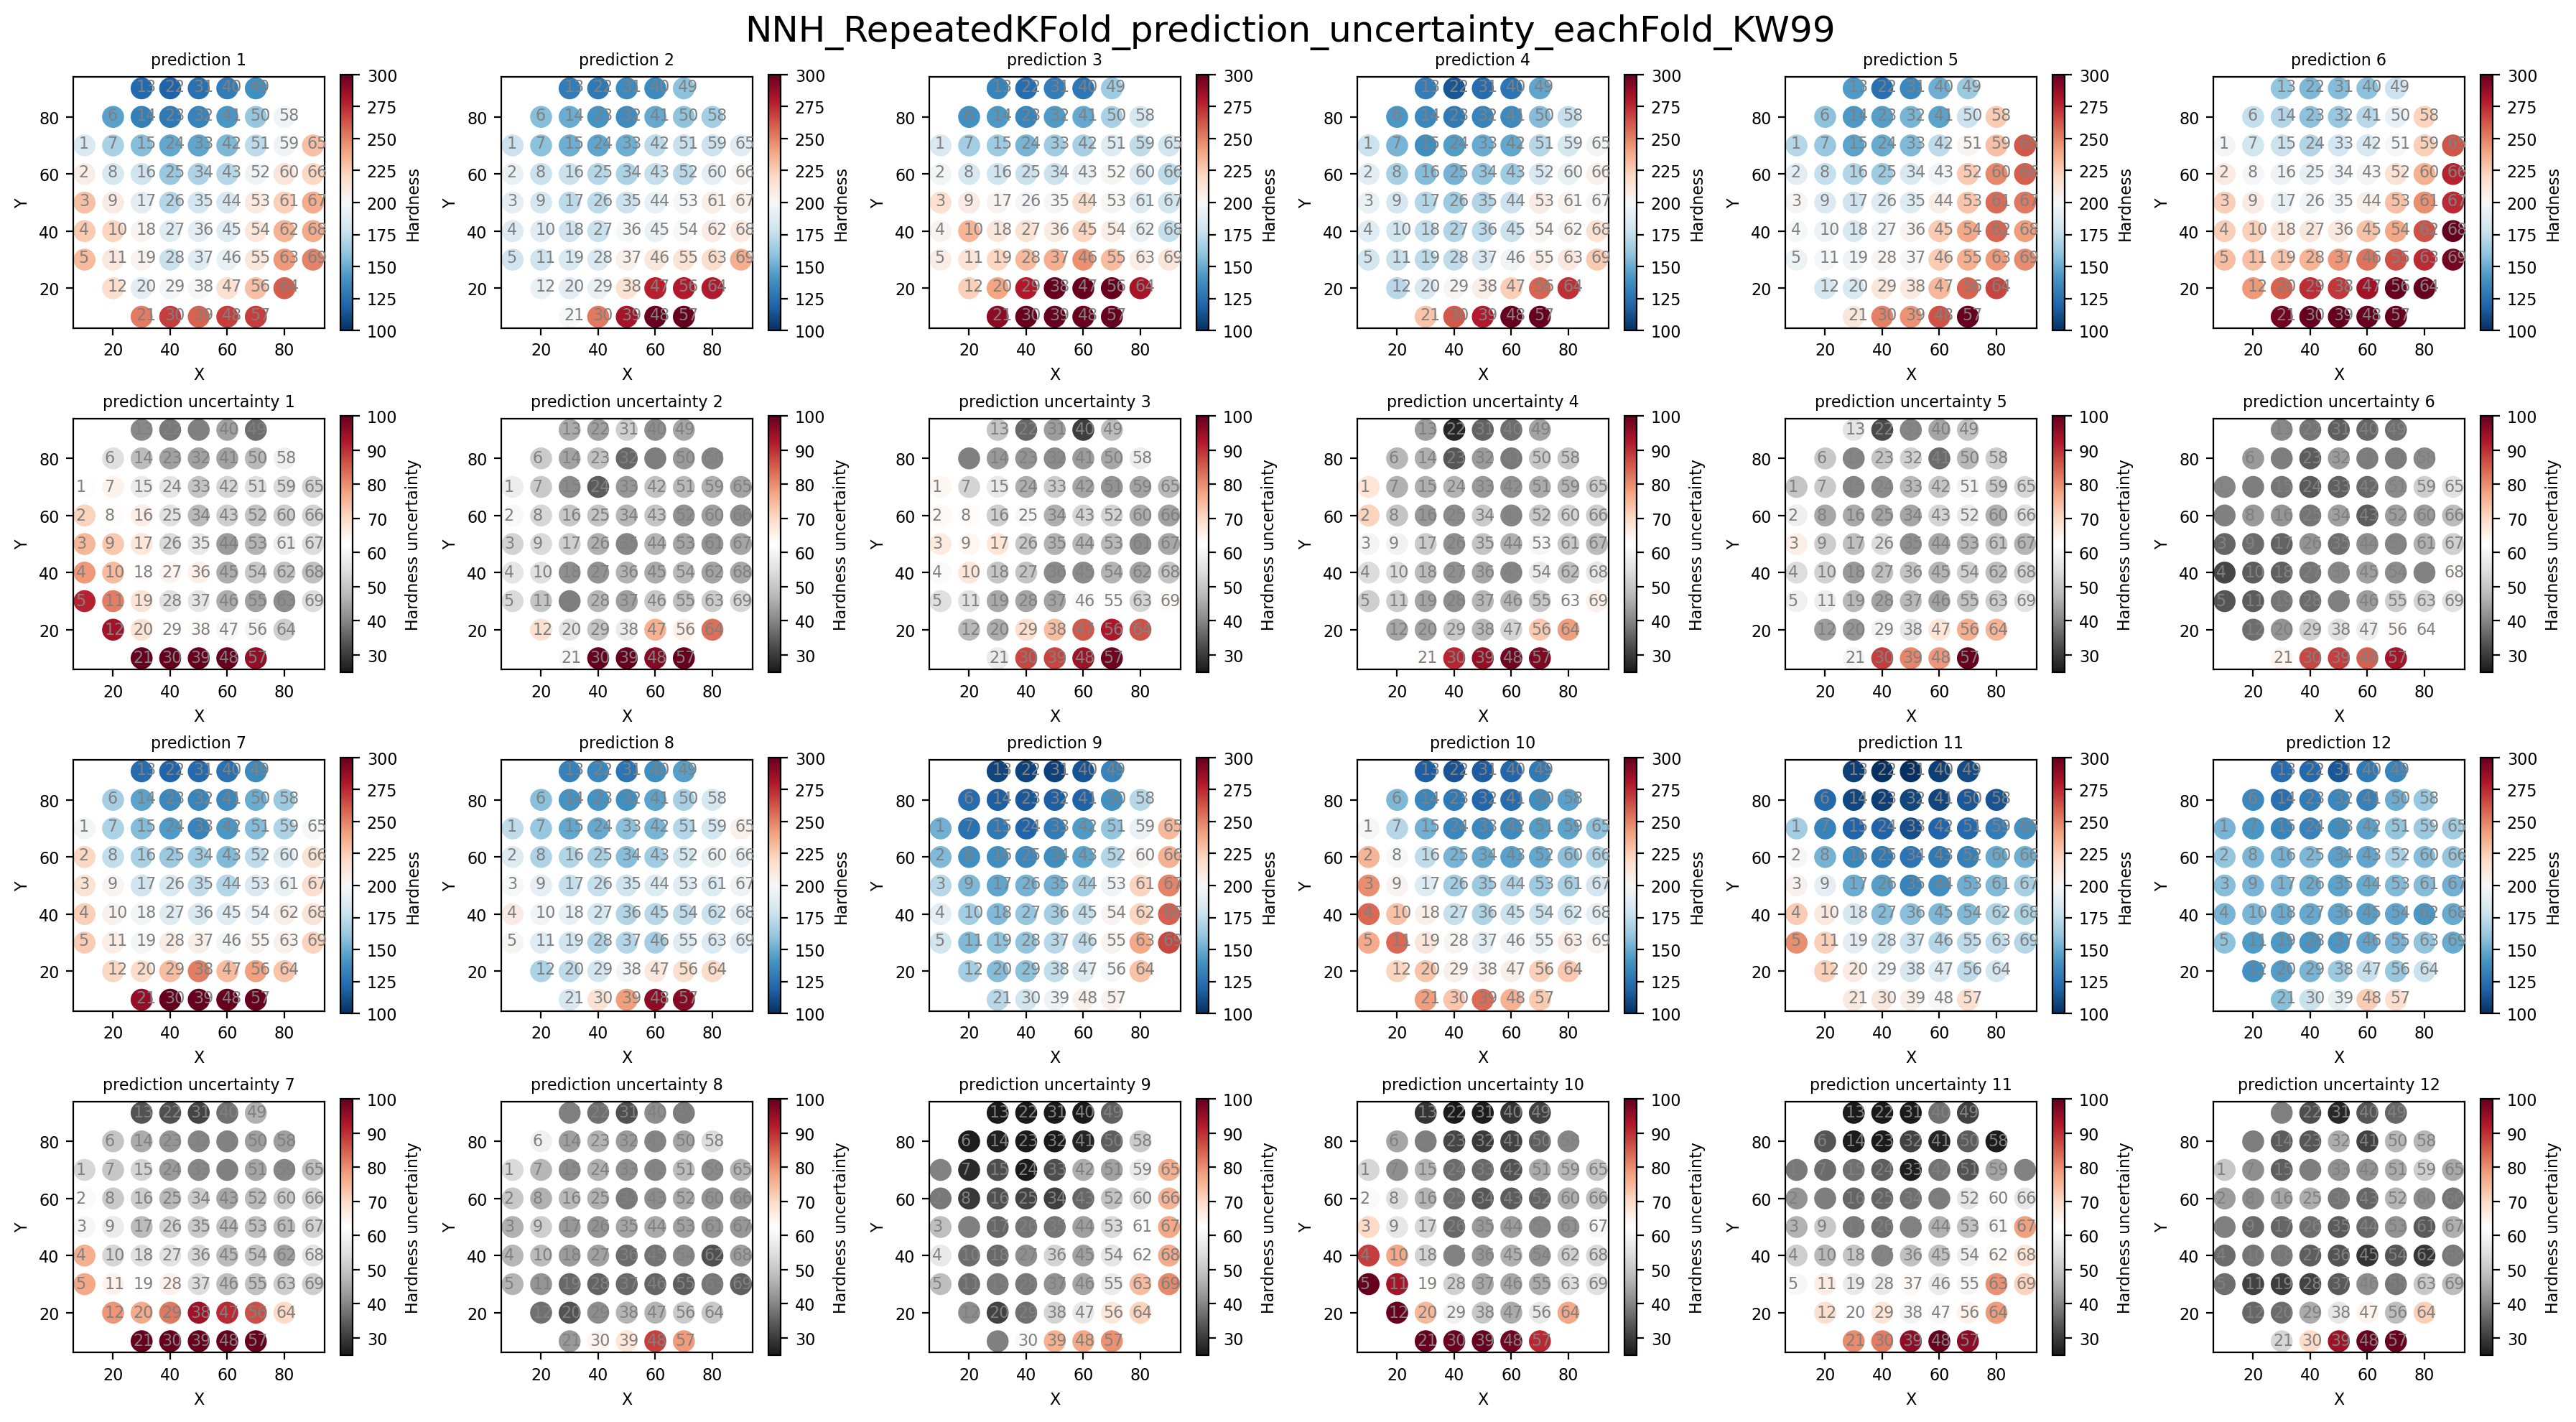

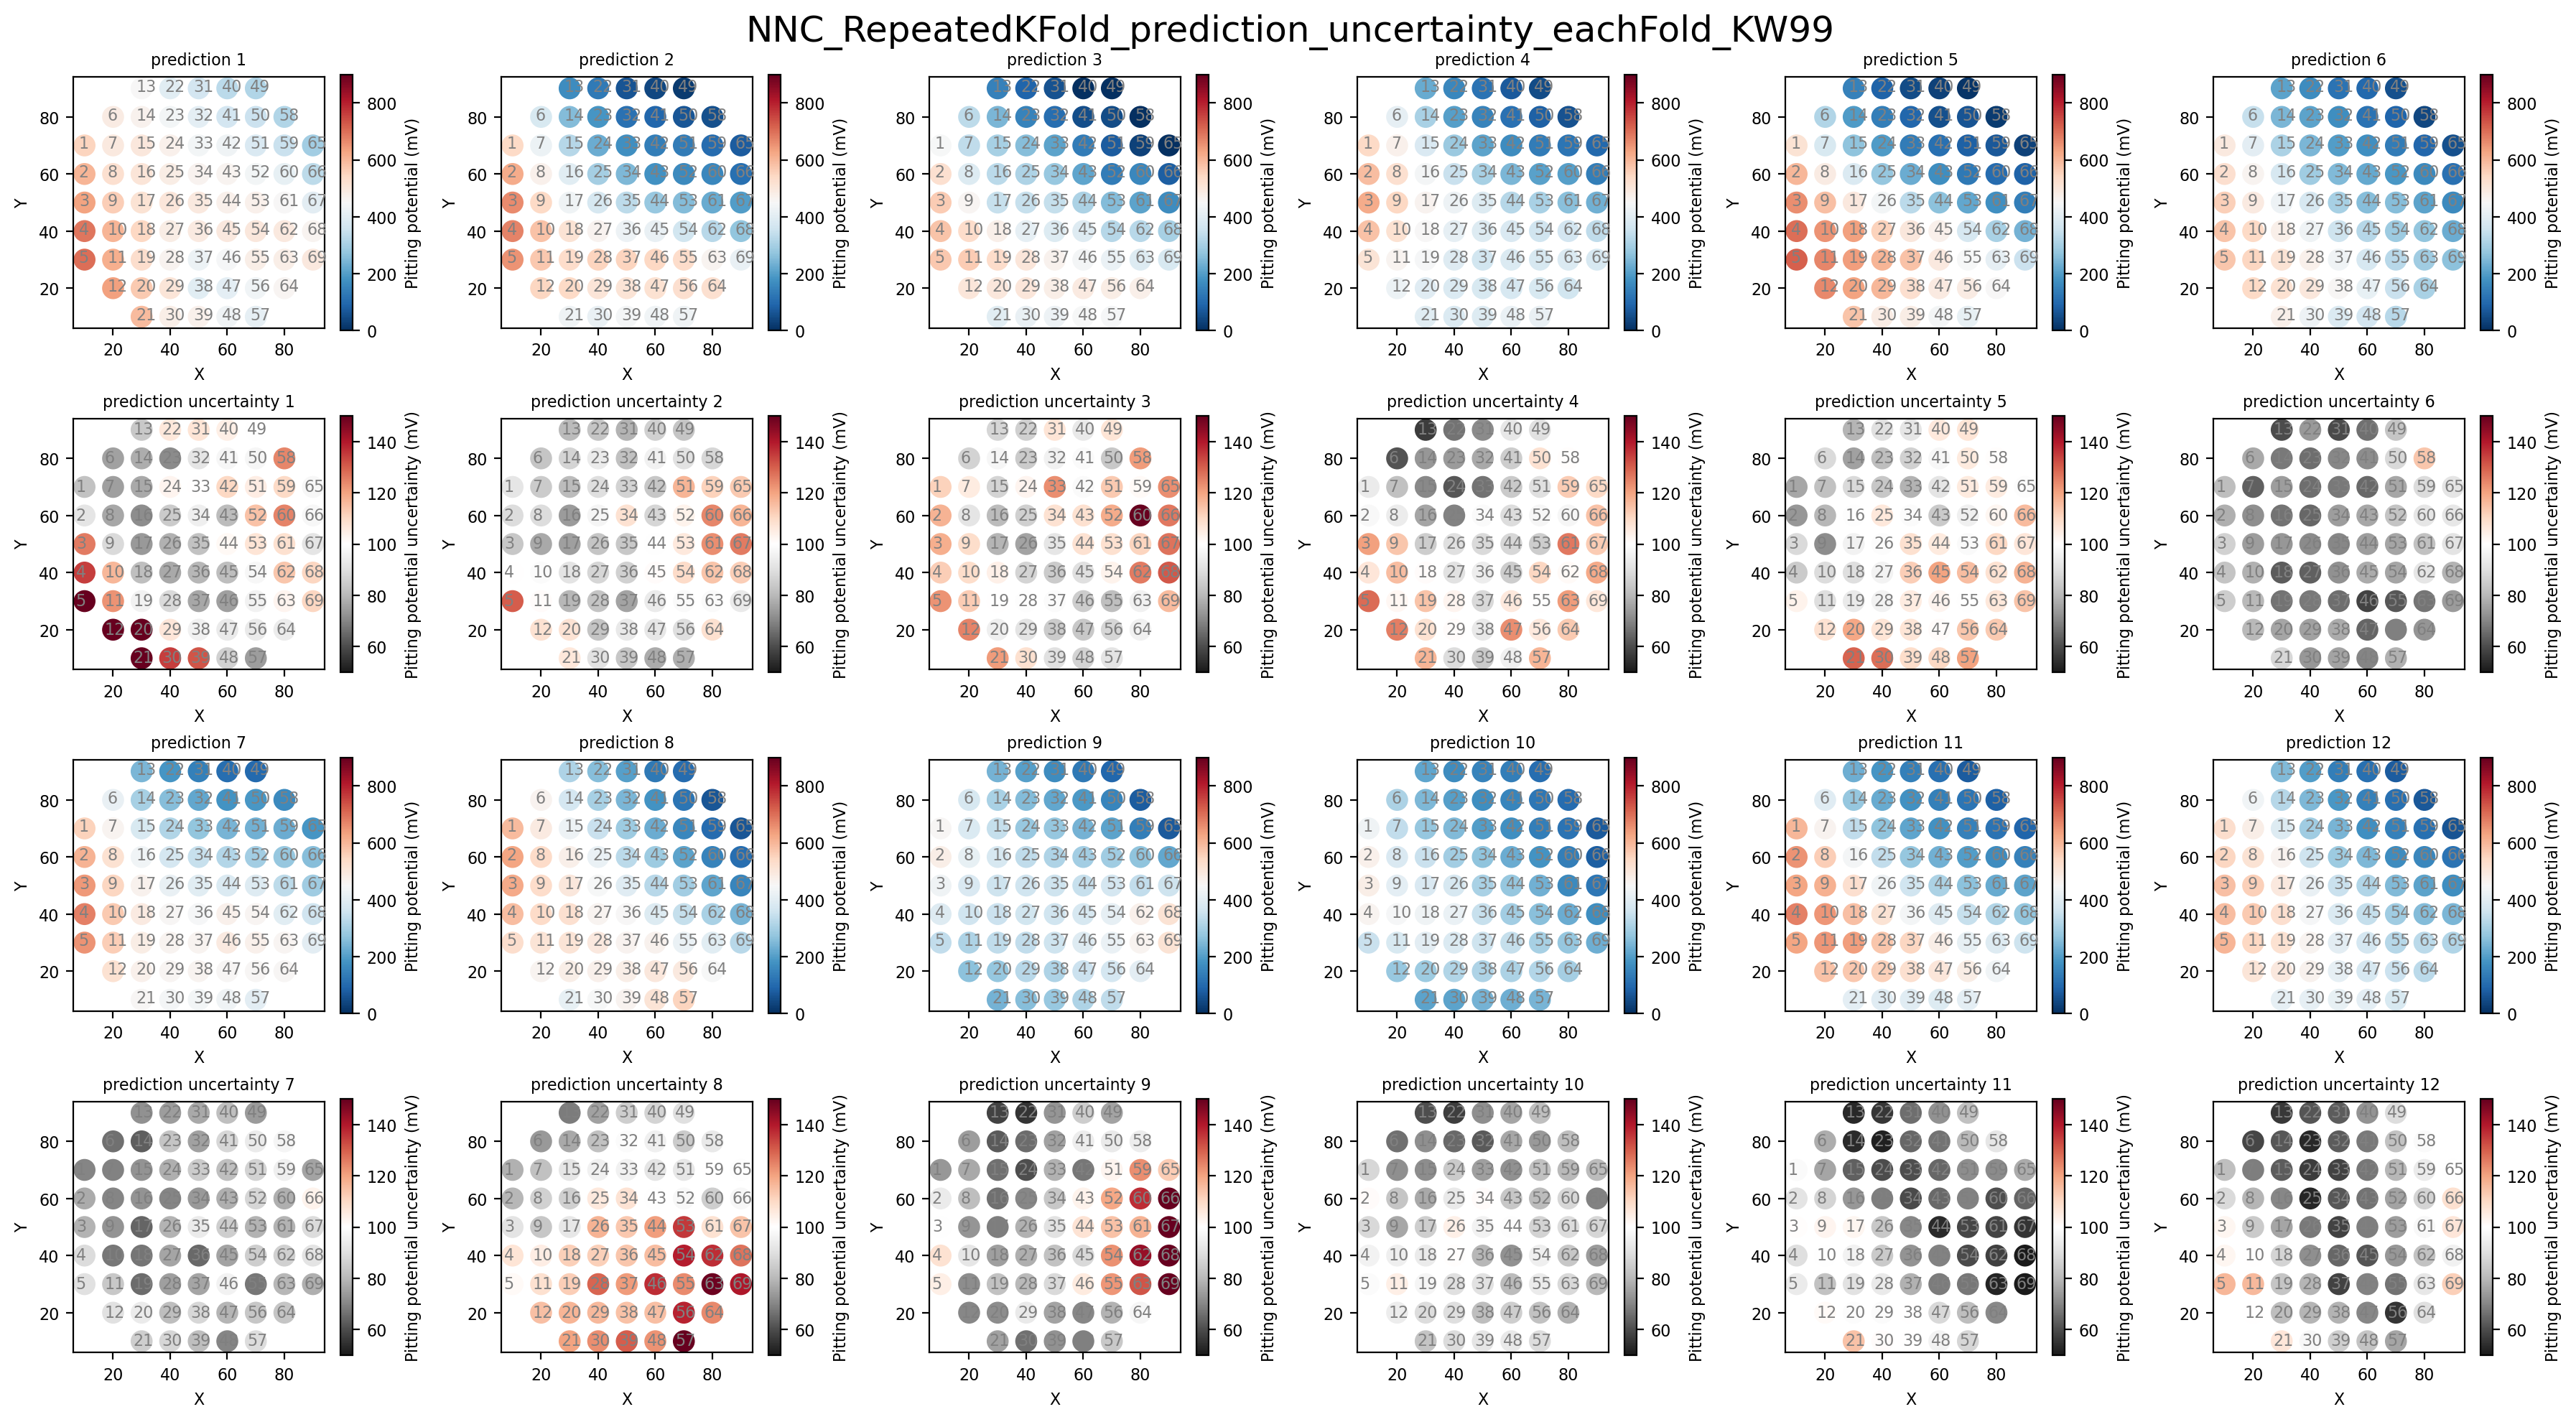

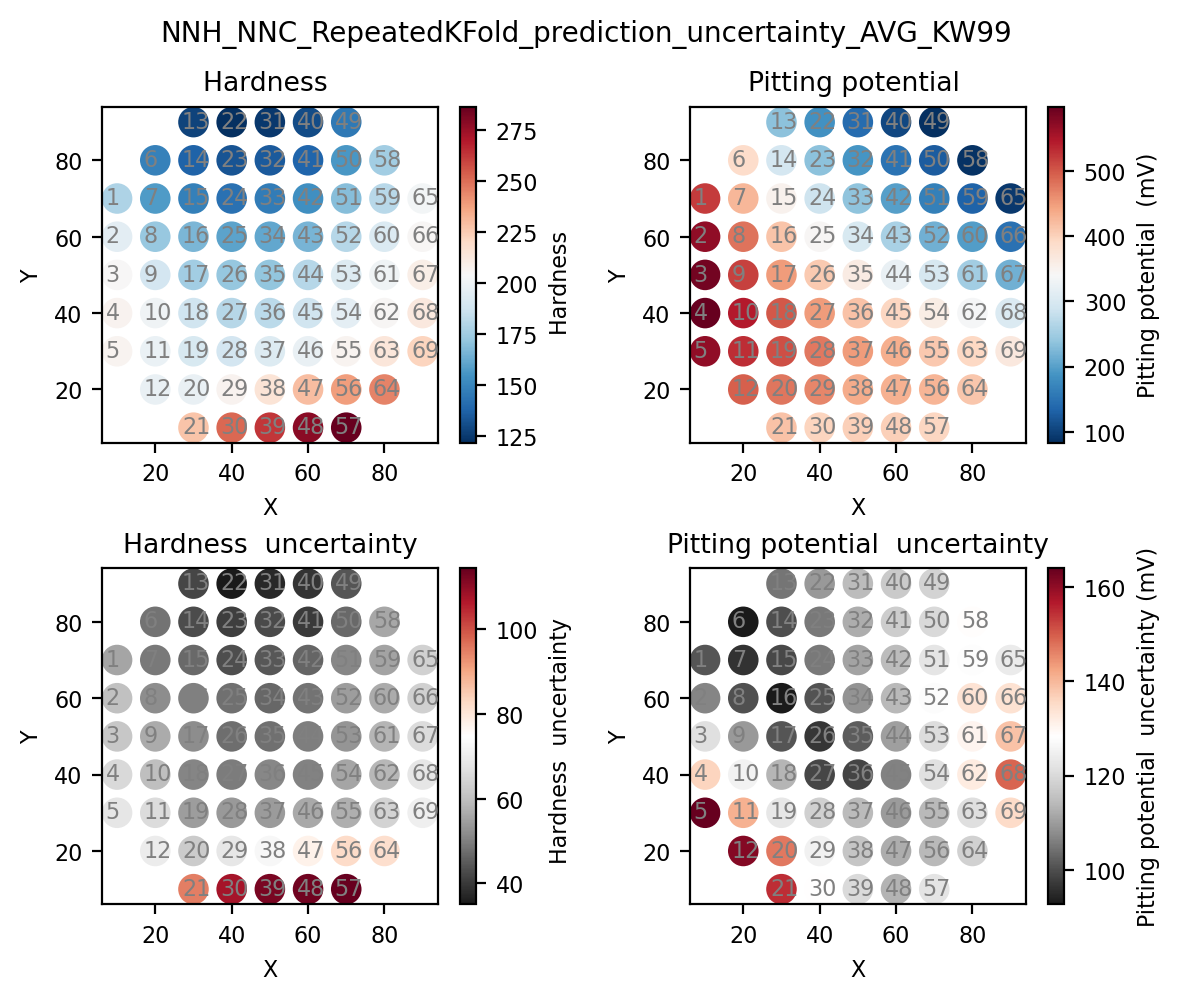

In [ ]:
KW_name = 'KW99'
vars_ele = ['Fe', 'Cr', 'Ni', 'Co', 'V']
k_folds = 6
n_CVrepeats = 2
mc_repeat = 100

NNH_model_name = 'NNH_model_RepeatedKFold_{}.h5'
NNC_model_name = 'NNC_model_RepeatedKFold_{}.h5'


compo_new, H_specific_new, C_specific_new = read_new_data(
    data_path, KW_name, vars_ele)

(H1_new_pred_stack, H1_new_pred_mean, H1_new_pred_std,
 C2_new_pred_stack, C2_new_pred_mean, C2_new_pred_std) = predict_bootstrap_NNH_NNC(
    model_path_bo, NNH_model_name, NNC_model_name,
    compo_new, H_specific_new, C_specific_new,
    scaler_compo, scaler_H_specific, scaler_C_specific,
    scaler_H_output, scaler_C_output,
    k_folds, n_CVrepeats, mc_repeat)

# NNH predictions
pred_label, unc_label = 'Hardness', 'Hardness uncertainty'
title = 'NNH_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name
vmin1, vmax1 = 100, 300
vmin2, vmax2 = 25, 100
plot_prediction_uncertainty(coord_x, coord_y, index_PVD_x_y, H1_new_pred_mean, H1_new_pred_std,
                            pred_label, unc_label, title, vmin1, vmax1, vmin2, vmax2, model_path_bo)

# NNC predictions
pred_label, unc_label = 'Pitting potential (mV)', 'Pitting potential uncertainty (mV)'
title = 'NNC_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name
vmin1, vmax1 = 0,  900
vmin2, vmax2 = 50, 150
plot_prediction_uncertainty(coord_x, coord_y, index_PVD_x_y, C2_new_pred_mean, C2_new_pred_std,
                            pred_label, unc_label, title, vmin1, vmax1, vmin2, vmax2, model_path_bo)

# NNH_NNC_AVG predictions
title = 'NNH_NNC_RepeatedKFold_prediction_uncertainty_AVG_' + KW_name
plot_prediction_uncertainty_AVG(coord_x, coord_y, index_PVD_x_y, H1_new_pred_stack, C2_new_pred_stack,
                                title, KW_name, model_path_bo)

#### Load the inputs for making predictions: KW99


In [ ]:
# # ----- import the new dataset -----
# # df_new_at = pd.read_excel(data_path + 'MultiTaskModel_corrosion_PT1_KW131_at_pct.xlsx')
# # df_new_wt = pd.read_excel(data_path + 'MultiTaskModel_corrosion_PT1_KW131_wt_pct.xlsx')
# # vars_ele  = ['Fe', 'Cr', 'Ni', 'Mo', 'Ti']
# # KW_name   = 'KW131'

# df_new_at = pd.read_excel(data_path + 'MultiTaskModel_KW99_at_pct.xlsx')
# df_new_wt = pd.read_excel(data_path + 'MultiTaskModel_KW99_wt_pct.xlsx')
# vars_ele  = ['Fe', 'Cr', 'Ni', 'Co', 'V']
# KW_name   = 'KW99'


# # ----- get the `df_compo_new` ------
# df_compo = pd.DataFrame(columns=['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn',
#        'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf'])

# df_compo_new = pd.concat([df_compo, df_new_wt[vars_ele]], axis=0, ignore_index=True)
# df_compo_new = df_compo_new.fillna(0) # fill in the nan by zero

# compo_new    = np.asarray(df_compo_new.values)


# # ----- get the `df_H_specific_new` -----
# df_H_specific_new = df_new_at[['delta_a', 'Hmix', 'VEC', 'sigma_bulk_modulus']]

# H_specific_new = np.asarray(df_H_specific_new.values)


# # ----- get the `df_C_specifi_new` -----
# C_testing = np.array([25, 0.5, 7, 0.215]) # TestTemperature_C, ChlorideIonConcentration, pH, ScanRate_mVs
# C_specific_new = np.ones((len(df_compo_new. index), len(C_testing))) * C_testing # corrosion testing condition array

# df_C_specific_new = pd.DataFrame(C_specific_new, columns=['TestTemperature_C', 'ChlorideIonConcentration', 'pH', 'ScanRate_mVs'])

#### make predictions for new alloys: KW99


In [ ]:
# mc_repeat  = 100

# NNH_model_name = 'NNH_model_RepeatedKFold_{}.h5'
# NNC_model_name = 'NNC_model_RepeatedKFold_{}.h5'

# compo_new_list      = [compo_new]*k_folds*n_CVrepeats
# H_specific_new_list = [H_specific_new]*k_folds*n_CVrepeats
# C_specific_new_list = [C_specific_new]*k_folds*n_CVrepeats

# with concurrent.futures.ThreadPoolExecutor() as executor:
#     future1 = executor.submit(predict_bootstrap, model_path_bo, NNH_model_name,
#                                                  compo_new_list, H_specific_new_list,
#                                                  k_folds, n_CVrepeats, mc_repeat,
#                                                  scaler_compo, scaler_H_specific, scaler_H_output)

#     future2 = executor.submit(predict_bootstrap, model_path_bo, NNC_model_name,
#                                                  compo_new_list, C_specific_new_list,
#                                                  k_folds, n_CVrepeats, mc_repeat,
#                                                  scaler_compo, scaler_C_specific, scaler_C_output)

# H1_new_pred_stack, H1_new_pred_mean, H1_new_pred_std = future1.result()
# C2_new_pred_stack, C2_new_pred_mean, C2_new_pred_std = future2.result()

#### plotting for prediction and uncertainty on wafer-coordinates: KW99


In [ ]:
# pred_label, unc_label = 'Hardness prediction', 'Hardness prediction uncertainty'
# title                 = 'NNH_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name
# vmin1, vmax1          = 100, 300
# vmin2, vmax2          = 25, 100
# plot_prediction_uncertainty(coord_x, coord_y, index_PVD_x_y, H1_new_pred_mean, H1_new_pred_std,
#                             pred_label, unc_label, title, vmin1, vmax1, vmin2, vmax2, model_path_bo)

# pred_label, unc_label = 'Pitting potential prediction (mV)', 'Pitting potential prediction uncertainty (mV)'
# title                 = 'NNC_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name
# vmin1, vmax1          = 0,  900
# vmin2, vmax2          = 50, 150
# plot_prediction_uncertainty(coord_x, coord_y, index_PVD_x_y, C2_new_pred_mean, C2_new_pred_std,
#                             pred_label, unc_label, title, vmin1, vmax1, vmin2, vmax2, model_path_bo)

#### make predictions for new alloys: averaged over bootstrap: KW99


In [ ]:
# # ----- concatenate and compute mean and std -----
# H1_new_pred_KFold_mean = np.mean(np.concatenate(H1_new_pred_stack, axis=0), axis=0).reshape(-1)
# H1_new_pred_KFold_std  = np.std(np.concatenate(H1_new_pred_stack, axis=0), axis=0).reshape(-1)

# C2_new_pred_KFold_mean = np.mean(np.concatenate(C2_new_pred_stack, axis=0), axis=0).reshape(-1)
# C2_new_pred_KFold_std  = np.std(np.concatenate(C2_new_pred_stack, axis=0), axis=0).reshape(-1)

# # ----- plot true vs prediction for all the RepeatedKFold + MC_dropout -----
# # Set font size for all text in figure
# plt.rcParams.update({'font.size': 8})

# # Create figure with 2 subplots
# fig, ax = plt.subplots(2, 2, figsize=(8, 7))

# # Define plot details
# plot_details = [ (H1_new_pred_KFold_mean, H1_new_pred_KFold_std, 'Hardness', 'VHN'),
#                  (C2_new_pred_KFold_mean, C2_new_pred_KFold_std, 'Pitting potential', 'mV')]

# # Loop through plot details and create subplots
# for i, (mean, std, name, unit) in enumerate(plot_details):
#     row, col = i // 2, i % 2
#     cmap1, cmap2 = plt.get_cmap('RdBu_r'), plt.get_cmap('RdGy_r')
#     cax1 = ax[row, col].scatter(coord_x, coord_y, c=mean, s=400, marker='.', cmap=cmap1)
#     cax2 = ax[row+1, col].scatter(coord_x, coord_y, c=std, s=400, marker='.', cmap=cmap2)
#     ax[row, col].set_title(f'{name} prediction')
#     ax[row+1, col].set_title(f'{name} prediction uncertainty')
#     ax[row, col].set_aspect('equal')
#     ax[row+1, col].set_aspect('equal')
#     ax[row, col].set_xlabel('X')
#     ax[row, col].set_ylabel('Y')
#     ax[row+1, col].set_xlabel('X')
#     ax[row+1, col].set_ylabel('Y')
#     for i_pvd, txt in enumerate(index_PVD_x_y):
#         ax[row, col].annotate(txt, (coord_x[i_pvd]-2, coord_y[i_pvd]-1), color="grey", alpha=1)
#         ax[row+1, col].annotate(txt, (coord_x[i_pvd]-2, coord_y[i_pvd]-1), color="grey", alpha=1)
#     cbar1, cbar2 = fig.colorbar(cax1, ax=ax[row, col]), fig.colorbar(cax2, ax=ax[row+1, col])
#     cbar1.set_label(f'{name} prediction ({unit})')
#     cbar2.set_label(f'{name} prediction uncertainty ({unit})')

# # Save and show figure
# plt.savefig(model_path_bo + 'NN_full_RepeatedKFold_prediction_uncertainty_AVG_' + KW_name + '.png', bbox_inches='tight')
# plt.show()